# Start

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio.Seq import Seq, MutableSeq
from Bio import SeqIO
from Bio.Data.CodonTable import unambiguous_dna_by_id
from Bio.SeqUtils import seq3
from Bio.SeqFeature import CompoundLocation
import warnings

In [ ]:
# selecting rows in the df with only 12 basic substitutions in 'ref' and 'alt' columns
substitutions = []
for i in ['A', 'C', 'G', 'T']:
    for q in ['A', 'C', 'G', 'T']:
        if q == i:
            continue
        substitutions.append(f'{i}>{q}')
print(substitutions)

['A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'G>A', 'G>C', 'G>T', 'T>A', 'T>C', 'T>G']


In [6]:
def subs_length_checker(subs_number):
    if len(subs_number) < 12:
        for sub in substitutions:
            if sub not in subs_number:
                subs_number[sub[0],sub[2]] = 0
        subs_number.sort_index(inplace=True)

In [11]:
# extraction of only synonymous variants
def syn_subs_extracter(only_subs_df, cds_list, refseq):
    syn_subs_ids = []
    for cds in cds_list:
        start = cds.location.start
        end = cds.location.end
        gene_df = only_subs_df.loc[(only_subs_df.position > start) & (only_subs_df.position < end)]
        sequence = refseq.seq[start-1:end-1]
        protein = sequence.translate(table=2, to_stop=True)
        for idx in range(len(gene_df)):
            sub = gene_df.iloc[idx]
            position = int(sub.position)
            mut_sequence = MutableSeq(refseq.seq)
            mut_sequence[position-1] = sub.alt
            mut_sequence = mut_sequence[start-1:end-1]
            mut_protein = mut_sequence.translate(table=2, to_stop=True)
            if protein == mut_protein:
                syn_subs_ids.append(sub.name)  # pd.Series.name here is an index in main DF
    return only_subs_df.loc[syn_subs_ids]

# Cancer data

In [88]:
cancer_df = pd.read_excel(r'D:\Downloads\Telegram Desktop\TT.xlsx').copy()
cancer_df

,sample_id,cancer_type,chrom,position,ref,var,var_type,Unnamed: 7
0,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder-TCC,MT,2680,T,C,ncUTR,NaN
1,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder-TCC,MT,6011,T,C,synSNP,NaN
2,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder-TCC,MT,7706,G,A,nsSNP,NaN
3,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder-TCC,MT,9078,T,C,synSNP,NaN
4,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder-TCC,MT,9686,T,C,synSNP,NaN
...,...,...,...,...,...,...,...,...
7606,PCSI_0357,Panc-AdenoCA,MT,3973,T,C,nsSNP,NaN
7607,PCSI_0357,Panc-AdenoCA,MT,5227,G,A,nsSNP,NaN
7608,PCSI_0357,Panc-AdenoCA,MT,11711,G,A,nsSNP,NaN
7609,PCSI_0357,Panc-AdenoCA,MT,13352,T,C,nsSNP,NaN


In [ ]:
cancer_df[(cancer_df.ref=='T') & (cancer_df['var']=='C')]

,sample_id,cancer_type,chrom,position,ref,var,var_type,Unnamed: 7
0,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder-TCC,MT,2680,T,C,ncUTR,NaN
1,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder-TCC,MT,6011,T,C,synSNP,NaN
3,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder-TCC,MT,9078,T,C,synSNP,NaN
4,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder-TCC,MT,9686,T,C,synSNP,NaN
6,178b28cd-99c3-48dc-8d09-1ef71b4cee80,Bladder-TCC,MT,152,T,C,LocInfo,NaN
...,...,...,...,...,...,...,...,...
7594,CPCG0046,Prost-AdenoCA,MT,2510,T,C,ncUTR,NaN
7600,CPCG0046,Prost-AdenoCA,MT,10833,T,C,nsSNP,NaN
7604,PCSI_0357,Panc-AdenoCA,MT,2908,T,C,ncUTR,NaN
7606,PCSI_0357,Panc-AdenoCA,MT,3973,T,C,nsSNP,NaN


In [90]:
cancer_samples_number = 2658
subs_number_cancer = {}
for ref in ['A', 'C', 'G', 'T']:
    for var in ['A', 'C', 'G', 'T']:
        if ref == var:
            continue
        variant_df = cancer_df.loc[(cancer_df['ref']==ref) & (cancer_df['var']==var)]
        subs_number_cancer[f'{ref}_{var}'] = len(variant_df) / cancer_samples_number #/ helix_base_freq[ref]
subs_number_cancer

{'A_C': 0.03423626787057938,
 'A_G': 0.18096313017306245,
 'A_T': 0.02708803611738149,
 'C_A': 0.06282919488337095,
 'C_G': 0.008276899924755455,
 'C_T': 0.29006772009029347,
 'G_A': 1.3781038374717833,
 'G_C': 0.04477050413844996,
 'G_T': 0.018434913468773514,
 'T_A': 0.0109104589917231,
 'T_C': 0.7975921745673439,
 'T_G': 0.010158013544018058}

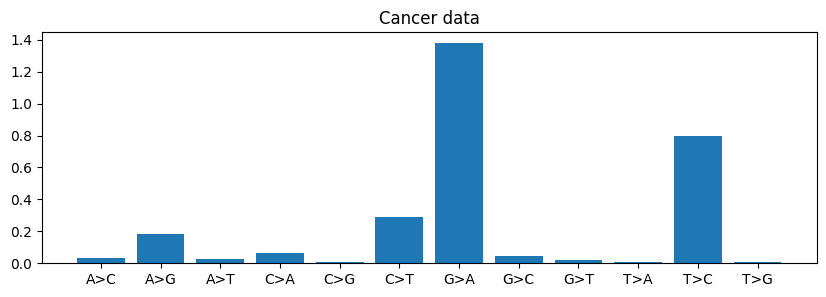

In [91]:
plt.figure(figsize=(10,3))
plt.bar(x=substitutions, height=subs_number_cancer.values())
plt.title(f'Cancer data')
plt.show()

# HelixMT

In [2]:
helix_samples_number =  196554
helix_df = pd.read_csv(r'C:\Work\Lab\pr-29-trna-or-mutagenesis\raw\HelixMTdb_20200327.tsv', sep='\t').copy()
helix_df

,locus,alleles,feature,gene,counts_hom,AF_hom,counts_het,AF_het,mean_ARF,max_ARF,haplogroups_for_homoplasmic_variants,haplogroups_for_heteroplasmic_variants
0,chrM:5,"[""A"",""C""]",non_coding,MT-CRb,1,0.000005,0,0.000000,NaN,NaN,"[[""H"",1]]",[]
1,chrM:10,"[""T"",""C""]",non_coding,MT-CRb,7,0.000036,1,0.000005,0.91892,0.91892,"[[""H"",7]]","[[""H"",1]]"
2,chrM:11,"[""C"",""T""]",non_coding,MT-CRb,0,0.000000,1,0.000005,0.60714,0.60714,[],"[[""H"",1]]"
3,chrM:12,"[""T"",""C""]",non_coding,MT-CRb,1,0.000005,0,0.000000,NaN,NaN,"[[""D"",1]]",[]
4,chrM:16,"[""A"",""T""]",non_coding,MT-CRb,273,0.001393,4,0.000020,0.68971,0.92188,"[[""K"",246],[""U"",12],[""H"",7],[""V"",2],[""B"",1],[""...","[[""K"",2],[""L3"",1],[""U"",1]]"
...,...,...,...,...,...,...,...,...,...,...,...,...
14319,chrM:16558,"[""G"",""A""]",non_coding,MT-CR,3,0.000015,0,0.000000,NaN,NaN,"[[""J"",3]]",[]
14320,chrM:16559,"[""A"",""G""]",non_coding,MT-CR,9,0.000046,0,0.000000,NaN,NaN,"[[""A"",3],[""K"",3],[""H"",2],[""B"",1]]",[]
14321,chrM:16562,"[""T"",""C""]",non_coding,MT-CR,0,0.000000,1,0.000005,0.85714,0.85714,[],"[[""U"",1]]"
14322,chrM:16564,"[""A"",""G""]",non_coding,MT-CR,0,0.000000,1,0.000005,0.70000,0.70000,[],"[[""H"",1]]"


In [3]:
# unify helix_df to gnomad_df
helix_df['position'] = helix_df.locus.str[5:].astype(int)
helix_df[['ref', 'alt']] = helix_df.alleles.str.split(',', n=1, expand=True).astype(str)
helix_df.ref = helix_df.ref.str.strip('["]')
helix_df.alt = helix_df.alt.str.strip('["]')
helix_df = helix_df.reindex(columns=helix_df.columns[-3:].tolist() + helix_df.columns[2:-3].to_list())
helix_df.rename(columns={'counts_hom':'AC_hom', 'counts_het':'AC_het'}, inplace=True)
helix_df

,position,ref,alt,feature,gene,AC_hom,AF_hom,AC_het,AF_het,mean_ARF,max_ARF,haplogroups_for_homoplasmic_variants,haplogroups_for_heteroplasmic_variants
0,5,A,C,non_coding,MT-CRb,1,0.000005,0,0.000000,NaN,NaN,"[[""H"",1]]",[]
1,10,T,C,non_coding,MT-CRb,7,0.000036,1,0.000005,0.91892,0.91892,"[[""H"",7]]","[[""H"",1]]"
2,11,C,T,non_coding,MT-CRb,0,0.000000,1,0.000005,0.60714,0.60714,[],"[[""H"",1]]"
3,12,T,C,non_coding,MT-CRb,1,0.000005,0,0.000000,NaN,NaN,"[[""D"",1]]",[]
4,16,A,T,non_coding,MT-CRb,273,0.001393,4,0.000020,0.68971,0.92188,"[[""K"",246],[""U"",12],[""H"",7],[""V"",2],[""B"",1],[""...","[[""K"",2],[""L3"",1],[""U"",1]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14319,16558,G,A,non_coding,MT-CR,3,0.000015,0,0.000000,NaN,NaN,"[[""J"",3]]",[]
14320,16559,A,G,non_coding,MT-CR,9,0.000046,0,0.000000,NaN,NaN,"[[""A"",3],[""K"",3],[""H"",2],[""B"",1]]",[]
14321,16562,T,C,non_coding,MT-CR,0,0.000000,1,0.000005,0.85714,0.85714,[],"[[""U"",1]]"
14322,16564,A,G,non_coding,MT-CR,0,0.000000,1,0.000005,0.70000,0.70000,[],"[[""H"",1]]"


In [216]:
helix_df_singleton = helix_df[helix_df[['AC_het', 'AC_hom']].sum(axis=1) == 1]
helix_df_2_001 = helix_df[(helix_df[['AC_het', 'AC_hom']].sum(axis=1) > 1) & (helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.0001)]
helix_df_001_01 = helix_df[(helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.0001) & (helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.001)]
helix_df_01_1 = helix_df[(helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.001) & (helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.01)]
helix_df_1_10 = helix_df[(helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.01) & (helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.1)]
helix_df_10_ = helix_df[helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.1]
helix_dfs = {'singleton':helix_df_singleton, '2-0.1%':helix_df_2_001, '0.01-0.1%':helix_df_001_01, '0.1-1%':helix_df_01_1, '1-10%':helix_df_1_10, '>10%':helix_df_10_}

# values_list = []
# for df in helix_dfs.values():
#     values_list.append(len(df))
list(map(len, helix_dfs.values()))

[3385, 6015, 3502, 1122, 265, 35]

In [5]:
only_subs_helix_df = helix_df[((helix_df.ref.apply(len)) == 1) & ((helix_df.alt.apply(len) == 1))] #  | (helix_df.gene.isin(['MT-CRb', 'MT-CR']))
only_subs_helix_df

,position,ref,alt,feature,gene,AC_hom,AF_hom,AC_het,AF_het,mean_ARF,max_ARF,haplogroups_for_homoplasmic_variants,haplogroups_for_heteroplasmic_variants
0,5,A,C,non_coding,MT-CRb,1,0.000005,0,0.000000,NaN,NaN,"[[""H"",1]]",[]
1,10,T,C,non_coding,MT-CRb,7,0.000036,1,0.000005,0.91892,0.91892,"[[""H"",7]]","[[""H"",1]]"
2,11,C,T,non_coding,MT-CRb,0,0.000000,1,0.000005,0.60714,0.60714,[],"[[""H"",1]]"
3,12,T,C,non_coding,MT-CRb,1,0.000005,0,0.000000,NaN,NaN,"[[""D"",1]]",[]
4,16,A,T,non_coding,MT-CRb,273,0.001393,4,0.000020,0.68971,0.92188,"[[""K"",246],[""U"",12],[""H"",7],[""V"",2],[""B"",1],[""...","[[""K"",2],[""L3"",1],[""U"",1]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14319,16558,G,A,non_coding,MT-CR,3,0.000015,0,0.000000,NaN,NaN,"[[""J"",3]]",[]
14320,16559,A,G,non_coding,MT-CR,9,0.000046,0,0.000000,NaN,NaN,"[[""A"",3],[""K"",3],[""H"",2],[""B"",1]]",[]
14321,16562,T,C,non_coding,MT-CR,0,0.000000,1,0.000005,0.85714,0.85714,[],"[[""U"",1]]"
14322,16564,A,G,non_coding,MT-CR,0,0.000000,1,0.000005,0.70000,0.70000,[],"[[""H"",1]]"


In [7]:
only_subs_helix_df_singleton = only_subs_helix_df[only_subs_helix_df[['AC_het', 'AC_hom']].sum(axis=1) == 1]
only_subs_helix_df_2_001 = only_subs_helix_df[(only_subs_helix_df[['AC_het', 'AC_hom']].sum(axis=1) > 1) & (only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.0001)]
only_subs_helix_df_001_01 = only_subs_helix_df[(only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.0001) & (only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.001)]
only_subs_helix_df_01_1 = only_subs_helix_df[(only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.001) & (only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.01)]
only_subs_helix_df_1_10 = only_subs_helix_df[(only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.01) & (only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.1)]
only_subs_helix_df_10_ = only_subs_helix_df[only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.1]
only_subs_helix_dfs = {'singleton':only_subs_helix_df_singleton, '2-0.1%':only_subs_helix_df_2_001, '0.01-0.1%':only_subs_helix_df_001_01, '0.1-1%':only_subs_helix_df_01_1, '1-10%':only_subs_helix_df_1_10, '>10%':only_subs_helix_df_10_}
list(map(len, only_subs_helix_dfs.values()))

[2749, 5131, 3039, 909, 177, 22]

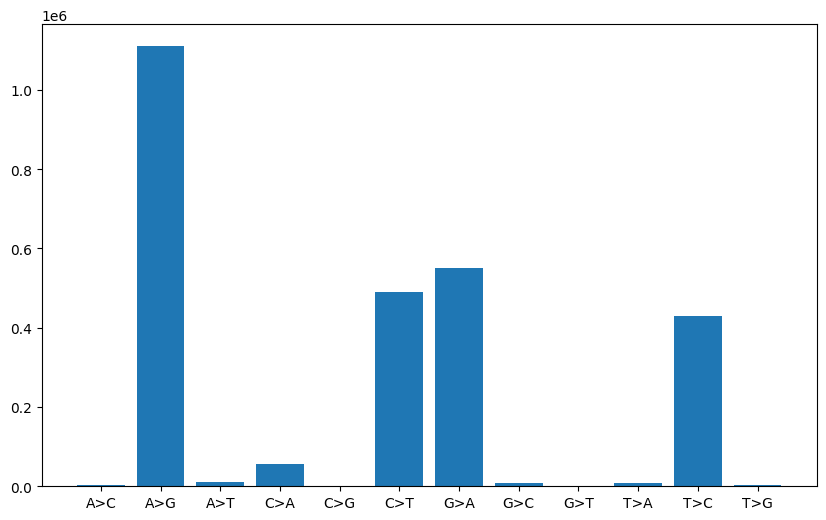

In [221]:
subs_number = only_subs_helix_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.show()

## RefSeq

In [20]:
refseq_helix = SeqIO.read(r"C:\Work\Lab\pr-29-trna-or-mutagenesis\raw\J01415.2.gb", "genbank")
helix_cds = []
for refseq_helix_feature in refseq_helix.features:
    if refseq_helix_feature.type == 'CDS': #  ['source', 'D-loop', 'gene', 'misc_feature']
        helix_cds.append(refseq_helix_feature)
helix_cds

[SeqFeature(SimpleLocation(ExactPosition(3306), ExactPosition(4262), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(4469), ExactPosition(5511), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(5903), ExactPosition(7445), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(7585), ExactPosition(8269), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(8365), ExactPosition(8572), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(8526), ExactPosition(9207), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(9206), ExactPosition(9990), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(10058), ExactPosition(10404), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(10469), ExactPosition(10766), strand=1), type='CDS', qualifiers=...),
 SeqFeature(Sim

In [ ]:
# locations_dict = {}
# for refseq_helix_feature in rCRS_cds:
#     start = refseq_helix_feature.location.nofuzzy_start
#     end = refseq_helix_feature.location.nofuzzy_end
#     location_name = refseq_helix_feature.qualifiers['gene'][0]
#     locations_dict[f'{start}-{end}'] = location_name
# locations_dict

In [21]:
# checking of substitutioning and reference bases match
for idx in range(len(only_subs_helix_df)):
    sub = only_subs_helix_df.iloc[idx]
    position = sub.position
    initial_base = sub.ref
    reference_base = refseq_helix.seq[position-1]
    if initial_base != reference_base:
        print(position, initial_base, reference_base)

In [6]:
for cds_loc in helix_cds:
    sequence = cds_loc.location.extract(refseq_helix.seq)
    protein = sequence.translate(table=2, to_stop=True)
    print(cds_loc.qualifiers['gene'], len(protein), protein)
# ND2 INP

['ND1'] 318 MPMANLLLLIVPILIAMAFLMLTERKILGYMQLRKGPNVVGPYGLLQPFADAMKLFTKEPLKPATSTITLYITAPTLALTIALLLWTPLPMPNPLVNLNLGLLFILATSSLAVYSILWSGWASNSNYALIGALRAVAQTISYEVTLAIILLSTLLMSGSFNLSTLITTQEHLWLLLPSWPLAMMWFISTLAETNRTPFDLAEGESELVSGFNIEYAAGPFALFFMAEYTNIIMMNTLTTTIFLGTTYDALSPELYTTYFVTKTLLLTSLFLWIRTAYPRFRYDQLMHLLWKNFLPLTLALLMWYVSMPITISSIPPQT
['ND2'] 347 INPLAQPVIYSTIFAGTLITALSSHWFFTWVGLEMNMLAFIPVLTKKMNPRSTEAAIKYFLTQATASMILLMAILFNNMLSGQWTMTNTTNQYSSLMIMMAMAMKLGMAPFHFWVPEVTQGTPLTSGLLLLTWQKLAPISIMYQISPSLNVSLLLTLSILSIMAGSWGGLNQTQLRKILAYSSITHMGWMMAVLPYNPNMTILNLTIYIILTTTAFLLLNLNSSTTTLLLSRTWNKLTWLTPLIPSTLLSLGGLPPLTGFLPKWAIIEEFTKNNSLIIPTIMATITLLNLYFYLRLIYSTSITLLPMSNNVKMKWQFEHTKPTPFLPTLIALTTLLLPISPFMLMIL
['COX1'] 513 MFADRWLFSTNHKDIGTLYLLFGAWAGVLGTALSLLIRAELGQPGNLLGNDHIYNVIVTAHAFVMIFFMVMPIMIGGFGNWLVPLMIGAPDMAFPRMNNMSFWLLPPSLLLLLASAMVEAGAGTGWTVYPPLAGNYSHPGASVDLTIFSLHLAGVSSILGAINFITTIINMKPPAMTQYQTPLFVWSVLITAVLLLLSLPVLAAGITMLLTDRNLNTTFFDPAGGGDPILYQHLFWFFGHPEVYILILPGFGMISHIVTYYSGKKEPFGYMGMVWAMMSIGFLGFIVWAHHMFTVG

c:\Soft\Python\lib\site-packages\Bio\Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [22]:
cds_subs_helix_df = only_subs_helix_df.loc[only_subs_helix_df.feature=='protein_coding_gene']
cds_subs_helix_df

,position,ref,alt,feature,gene,AC_hom,AF_hom,AC_het,AF_het,mean_ARF,max_ARF,haplogroups_for_homoplasmic_variants,haplogroups_for_heteroplasmic_variants
2799,3307,A,C,protein_coding_gene,MT-ND1,1,0.000005,0,0.000000,NaN,NaN,"[[""C"",1]]",[]
2800,3307,A,G,protein_coding_gene,MT-ND1,1,0.000005,2,0.000010,0.27253,0.31429,"[[""H"",1]]","[[""U"",2]]"
2801,3308,T,C,protein_coding_gene,MT-ND1,1126,0.005745,26,0.000133,0.50148,0.94643,"[[""L1"",850],[""A"",92],[""K"",51],[""L2"",38],[""H"",2...","[[""H"",8],[""A"",4],[""T"",3],[""J"",2],[""L1"",2],[""U""..."
2802,3308,T,G,protein_coding_gene,MT-ND1,89,0.000454,0,0.000000,NaN,NaN,"[[""T"",89]]",[]
2803,3309,A,G,protein_coding_gene,MT-ND1,1,0.000005,0,0.000000,NaN,NaN,"[[""K"",1]]",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13443,15885,C,A,protein_coding_gene,MT-CYB,1,0.000005,0,0.000000,NaN,NaN,"[[""V"",1]]",[]
13444,15885,C,T,protein_coding_gene,MT-CYB,126,0.000643,2,0.000010,0.29366,0.40550,"[[""H"",102],[""B"",13],[""R"",7],[""U"",2],[""X"",1],[""...","[[""K"",1],[""N"",1]]"
13445,15886,C,A,protein_coding_gene,MT-CYB,1,0.000005,0,0.000000,NaN,NaN,"[[""H"",1]]",[]
13446,15886,C,T,protein_coding_gene,MT-CYB,37,0.000189,3,0.000015,0.52856,0.61940,"[[""H"",11],[""M"",6],[""L1"",5],[""R"",4],[""C"",3],[""K...","[[""H"",1],[""U"",1],[""V"",1]]"


In [23]:
only_syn_helix_df = syn_subs_extracter(cds_subs_helix_df, helix_cds, refseq_helix)
only_syn_helix_df

c:\Soft\Python\Lib\site-packages\Bio\Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


,position,ref,alt,feature,gene,AC_hom,AF_hom,AC_het,AF_het,mean_ARF,max_ARF,haplogroups_for_homoplasmic_variants,haplogroups_for_heteroplasmic_variants
2801,3308,T,C,protein_coding_gene,MT-ND1,1126,0.005745,26,0.000133,0.50148,0.94643,"[[""L1"",850],[""A"",92],[""K"",51],[""L2"",38],[""H"",2...","[[""H"",8],[""A"",4],[""T"",3],[""J"",2],[""L1"",2],[""U""..."
2807,3311,C,T,protein_coding_gene,MT-ND1,21,0.000107,2,0.000010,0.49912,0.76699,"[[""HV"",12],[""A"",8],[""L3"",1]]","[[""H"",1],[""L2"",1]]"
2811,3317,C,G,protein_coding_gene,MT-ND1,2,0.000010,0,0.000000,NaN,NaN,"[[""H"",2]]",[]
2812,3317,C,T,protein_coding_gene,MT-ND1,6,0.000031,4,0.000020,0.16558,0.25714,"[[""M"",2],[""B"",1],[""J"",1],[""L1"",1],[""T"",1]]","[[""H"",1],[""I"",1],[""T"",1],[""U"",1]]"
2816,3320,A,G,protein_coding_gene,MT-ND1,14,0.000071,1,0.000005,0.10811,0.10811,"[[""C"",9],[""B"",2],[""R"",2],[""F"",1]]","[[""U"",1]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13442,15884,G,T,protein_coding_gene,MT-CYB,3,0.000015,1,0.000005,0.16154,0.16154,"[[""M"",3]]","[[""A"",1]]"
13443,15885,C,A,protein_coding_gene,MT-CYB,1,0.000005,0,0.000000,NaN,NaN,"[[""V"",1]]",[]
13444,15885,C,T,protein_coding_gene,MT-CYB,126,0.000643,2,0.000010,0.29366,0.40550,"[[""H"",102],[""B"",13],[""R"",7],[""U"",2],[""X"",1],[""...","[[""K"",1],[""N"",1]]"
13445,15886,C,A,protein_coding_gene,MT-CYB,1,0.000005,0,0.000000,NaN,NaN,"[[""H"",1]]",[]


In [17]:
only_syn_helix_df_singleton = only_syn_helix_df[only_syn_helix_df[['AC_het', 'AC_hom']].sum(axis=1) == 1]
only_syn_helix_df_2_001 = only_syn_helix_df[(only_syn_helix_df[['AC_het', 'AC_hom']].sum(axis=1) > 1) & (only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.0001)]
only_syn_helix_df_001_01 = only_syn_helix_df[(only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.0001) & (only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.001)]
only_syn_helix_df_01_1 = only_syn_helix_df[(only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.001) & (only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.01)]
only_syn_helix_df_1_10 = only_syn_helix_df[(only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.01) & (only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.1)]
only_syn_helix_df_10_ = only_syn_helix_df[only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.1]
only_syn_helix_dfs = {'singleton':only_syn_helix_df_singleton, '2-0.1%':only_syn_helix_df_2_001, '0.01-0.1%':only_syn_helix_df_001_01, '0.1-1%':only_syn_helix_df_01_1, '1-10%':only_syn_helix_df_1_10, '>10%':only_syn_helix_df_10_}
list(map(len, only_syn_helix_dfs.values())) 

[1851, 3806, 2439, 717, 137, 14]

In [120]:
# base_usage
base_freq = {base:refseq_helix.seq.count(base) for base in ['A', 'T', 'G', 'C']}
base_freq

{'A': 5124, 'T': 4094, 'G': 2169, 'C': 5181}

In [24]:
# synonymous base usage
helix_base_freq = {base:0 for base in ['A', 'T', 'G', 'C']}
for cds in helix_cds:
    start = cds.location.start
    end = cds.location.end
    gene_df = cds_subs_helix_df.loc[(cds_subs_helix_df.position > start) & (cds_subs_helix_df.position < end)]
    sequence = refseq_helix.seq[start-1:end-1]
    for base in ['A', 'T', 'G', 'C']:
        helix_base_freq[base] += sequence.count(base)
helix_base_freq

{'A': 3392, 'T': 2879, 'G': 1338, 'C': 3786}

## Synonymous subs

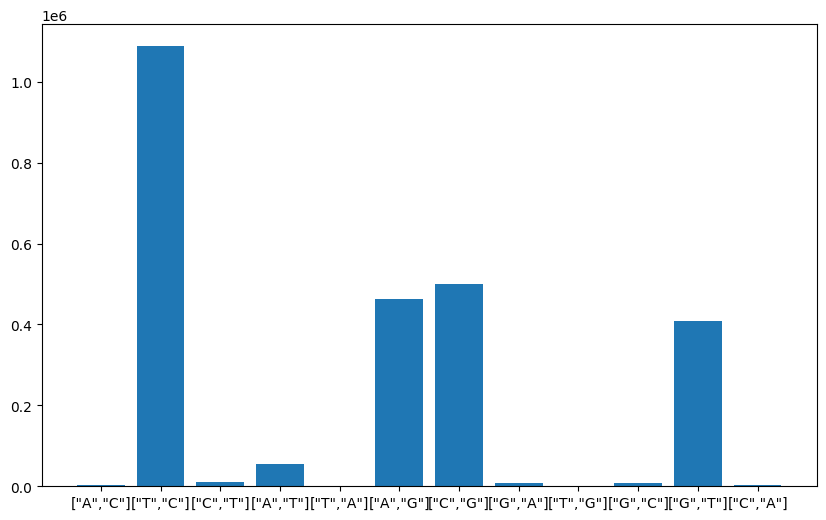

In [20]:
subs_number = only_syn_helix_df.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\3790884731.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.05100235849056604' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


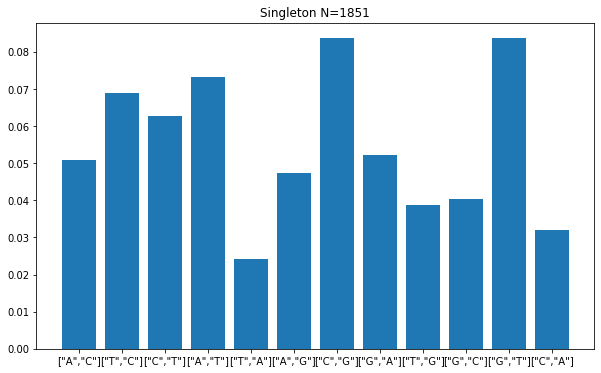

In [62]:
# only_syn_helix_df_singleton
subs_number = only_syn_helix_df_singleton.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'Singleton N={sample_size}')
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\1880290059.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.22169811320754718' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


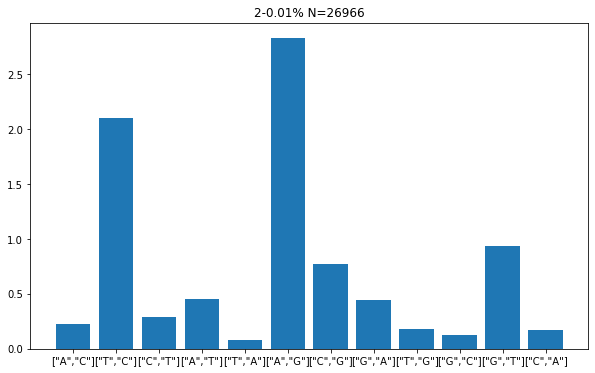

In [63]:
subs_number = only_syn_helix_df_2_001.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'2-0.01% N={sample_size}')
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\777798948.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.27682783018867924' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


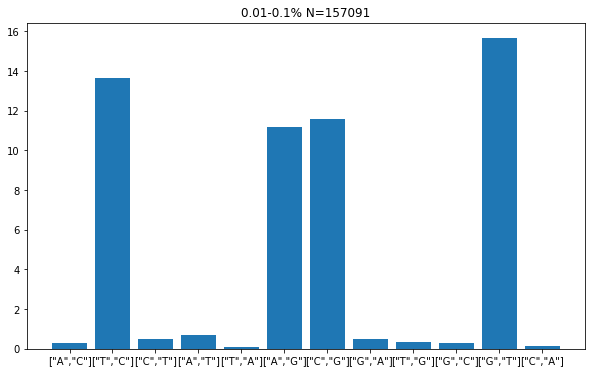

In [64]:
# only_syn_helix_df_singleton
subs_number = only_syn_helix_df_001_01.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.01-0.1% N={sample_size}')
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\2884042047.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5188679245283019' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


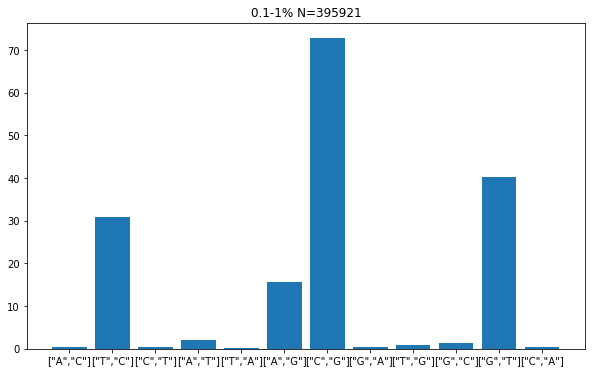

In [65]:
subs_number = only_syn_helix_df_01_1.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.1-1% N={sample_size}')
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\1299339104.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '67.2252358490566' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


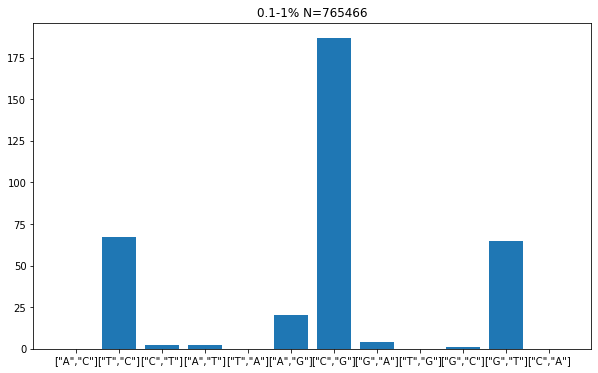

In [67]:
subs_number = only_syn_helix_df_1_10.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
subs_length_checker(subs_number)
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.1-1% N={sample_size}')
plt.show()

### Only empty haplogroups_for_heteroplasmic_variants

In [69]:
empty_het_haplogroups = only_syn_helix_df.loc[only_syn_helix_df.haplogroups_for_heteroplasmic_variants=='[]']
# empty_het_haplogroups

In [70]:
only_syn_het_df_singleton = empty_het_haplogroups[empty_het_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) == 1]
only_syn_het_df_2_001 = empty_het_haplogroups[(empty_het_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) > 1) & (empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.0001)]
only_syn_het_df_001_01 = empty_het_haplogroups[(empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.0001) & (empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.001)]
only_syn_het_df_01_1 = empty_het_haplogroups[(empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.001) & (empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.01)]
only_syn_het_df_1_10 = empty_het_haplogroups[(empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.01) & (empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.1)]
only_syn_het_df_10_ = empty_het_haplogroups[empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.1]
only_syn_het_dfs = {'singleton':only_syn_het_df_singleton, '2-0.1%':only_syn_het_df_2_001, '0.01-0.1%':only_syn_het_df_001_01, '0.1-1%':only_syn_het_df_01_1, '1-10%':only_syn_het_df_1_10, '>10%':only_syn_het_df_10_}
list(map(len, only_syn_het_dfs.values())) 

[809, 1407, 366, 21, 0, 0]

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_20472\1307832590.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.019711163153786106' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= base_freq[sub[2]]


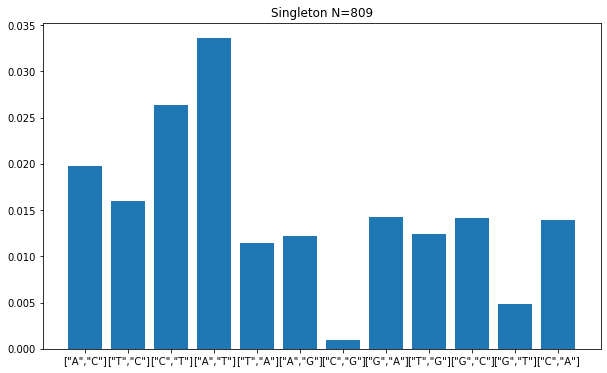

In [101]:
# only_syn_helix_df_singleton
subs_number = only_syn_het_df_singleton.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'Singleton N={sample_size}')
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\1701311826.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.1474056603773585' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


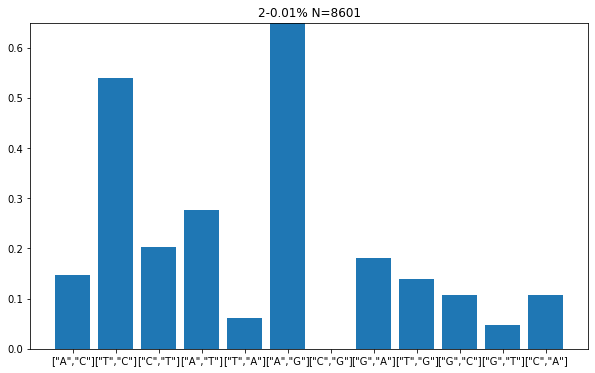

In [72]:
subs_number = only_syn_het_df_2_001.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'2-0.01% N={sample_size}')
plt.ylim(top=0.65)
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\2718111574.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.052181603773584904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


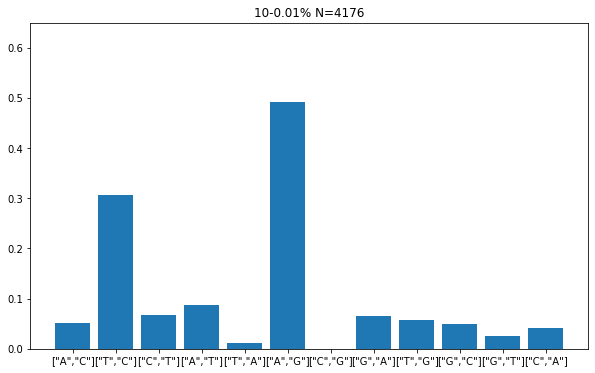

In [73]:
only_syn_het_df_10_001 = empty_het_haplogroups[(empty_het_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) > 9) & (empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.0001)]
subs_number = only_syn_het_df_10_001.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
if len(subs_number) < 12:
    for sub in substitutions:
        if sub not in subs_number:
            subs_number[sub] = 0
    subs_number.sort_index(inplace=True)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'10-0.01% N={sample_size}')
plt.ylim(top=0.65)
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\1062597119.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.09522405660377359' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


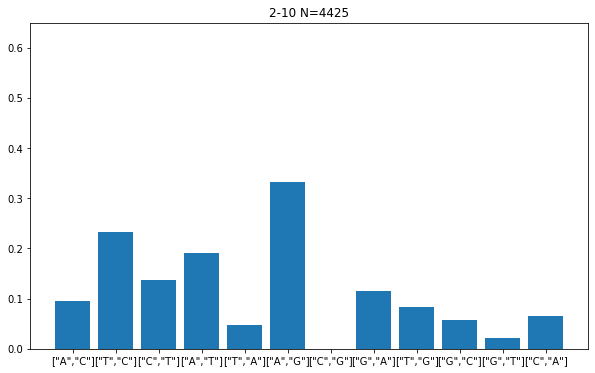

In [75]:
only_syn_het_df_2_10 = empty_het_haplogroups[(empty_het_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) <= 9) & (empty_het_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) > 1)]
subs_number = only_syn_het_df_2_10.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'2-10 N={sample_size}')
plt.ylim(top=0.65)
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\1174192494.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2514740566037736' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


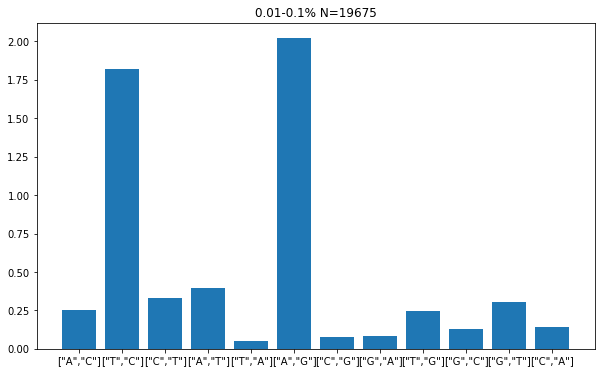

In [76]:
subs_number = only_syn_het_df_001_01.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.01-0.1% N={sample_size}')
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\2029386905.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.07222877358490566' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


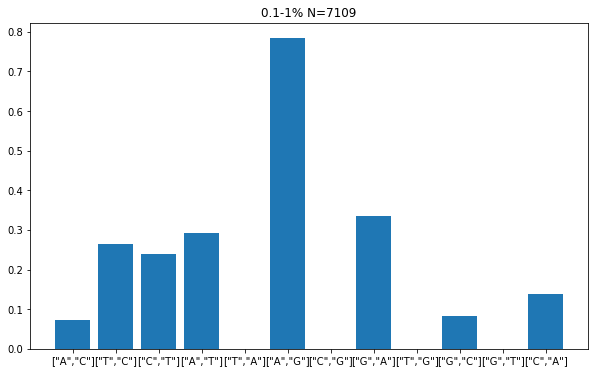

In [77]:
subs_number = only_syn_het_df_01_1.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.1-1% N={sample_size}')
plt.show()

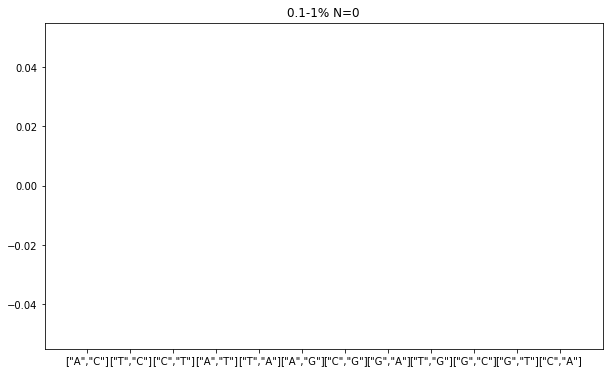

In [78]:
subs_number = only_syn_het_df_1_10.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.1-1% N={sample_size}')
plt.show()

### Only empty haplogroups_for_homoplasmic_variants

In [128]:
empty_hom_haplogroups = only_syn_helix_df.loc[only_syn_helix_df.haplogroups_for_homoplasmic_variants=='[]']
# empty_hom_haplogroups

In [83]:
only_syn_hom_df_singleton = empty_hom_haplogroups[empty_hom_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) == 1]
only_syn_hom_df_2_001 = empty_hom_haplogroups[(empty_hom_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) > 1) & (empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.0001)]
only_syn_hom_df_001_01 = empty_hom_haplogroups[(empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.0001) & (empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.001)]
only_syn_hom_df_01_1 = empty_hom_haplogroups[(empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.001) & (empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.01)]
only_syn_hom_df_1_10 = empty_hom_haplogroups[(empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.01) & (empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.1)]
only_syn_hom_df_10_ = empty_hom_haplogroups[empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.1]
only_syn_hom_dfs = {'singleton':only_syn_hom_df_singleton, '2-0.1%':only_syn_hom_df_2_001, '0.01-0.1%':only_syn_hom_df_001_01, '0.1-1%':only_syn_hom_df_01_1, '1-10%':only_syn_hom_df_1_10, '>10%':only_syn_hom_df_10_}
list(map(len, only_syn_hom_dfs.values())) 

[1042, 357, 3, 0, 0, 0]

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\616861362.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.02122641509433962' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


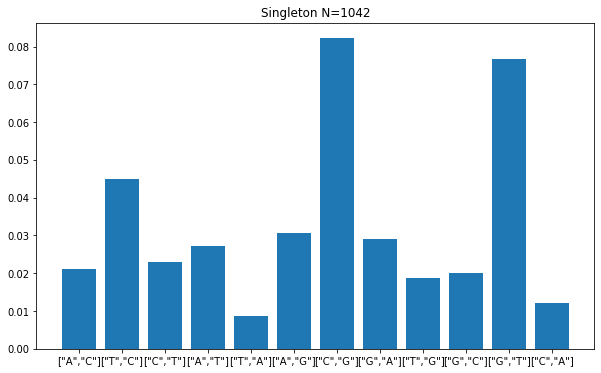

In [84]:
# only_syn_helix_df_singleton
subs_number = only_syn_hom_df_singleton.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'Singleton N={sample_size}')
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\1200568817.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.008549528301886792' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


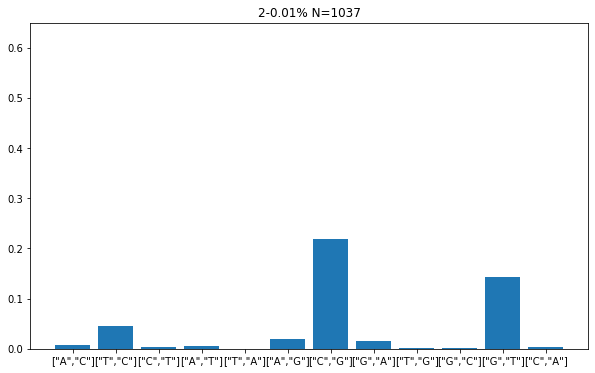

In [85]:
subs_number = only_syn_hom_df_2_001.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'2-0.01% N={sample_size}')
plt.ylim(top=0.65)
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\1131766124.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00294811320754717' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


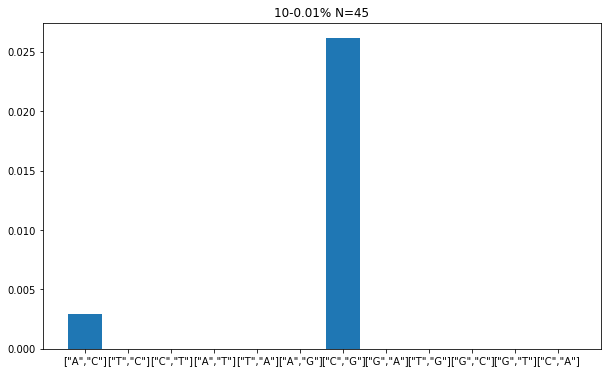

In [87]:
only_syn_hom_df_10_001 = empty_hom_haplogroups[(empty_hom_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) > 9) & (empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.0001)]
subs_number = only_syn_hom_df_10_001.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'10-0.01% N={sample_size}')
# plt.ylim(top=0.65)
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\3633893234.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.005601415094339622' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


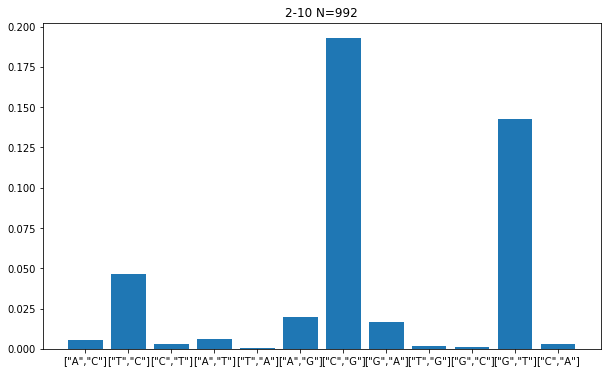

In [89]:
only_syn_hom_df_2_10 = empty_hom_haplogroups[(empty_hom_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) <= 9) & (empty_hom_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) > 1)]
subs_number = only_syn_hom_df_2_10.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
    subs_number[sub] /= 
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'2-10 N={sample_size}')
# plt.ylim(top=0.65)
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\4235216056.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.009433962264150943' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


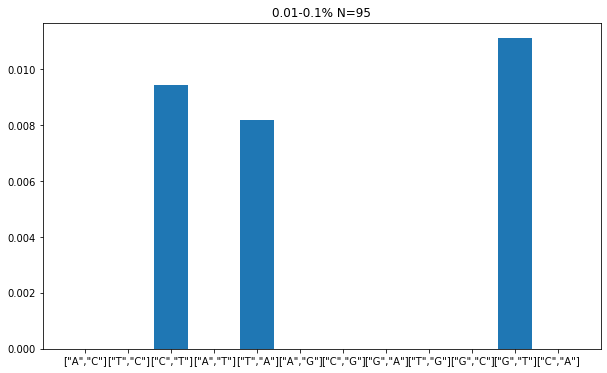

In [90]:
subs_number = only_syn_hom_df_001_01.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.01-0.1% N={sample_size}')
plt.show()

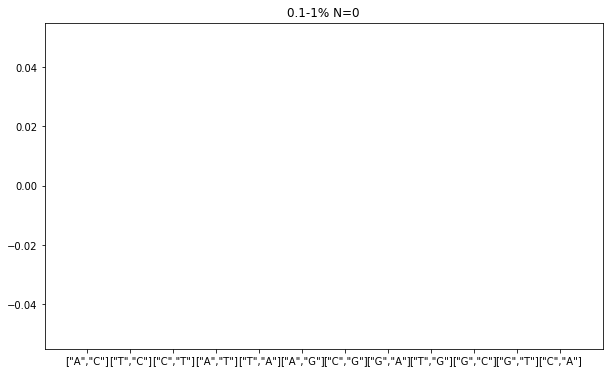

In [91]:
subs_number = only_syn_hom_df_01_1.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.1-1% N={sample_size}')
plt.show()

## Total Low and High VAF

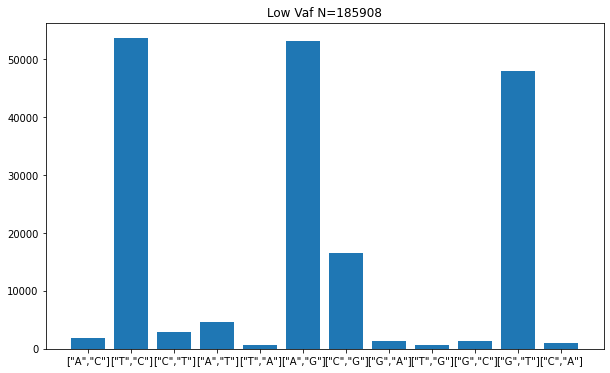

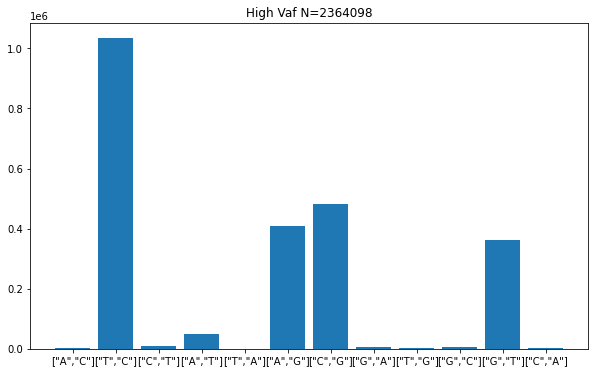

In [124]:
threshold = 0.001
top = 8 * 10**5
only_syn_helix_df_low_vaf = only_syn_helix_df[(only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= threshold) & (only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.000005)]
subs_number = only_syn_helix_df_low_vaf.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'Low Vaf N={subs_number.sum()}')
# plt.ylim(top=top)
plt.show()
only_syn_helix_df_high_vaf = only_syn_helix_df[(only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > threshold) & (only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.000005)]
subs_number = only_syn_helix_df_high_vaf.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
if len(subs_number) < 12:
    for sub in substitutions:
        if sub not in subs_number:
            subs_number[sub] = 0
    subs_number.sort_index(inplace=True)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'High Vaf N={subs_number.sum()}')
# plt.ylim(top=top)
plt.show()

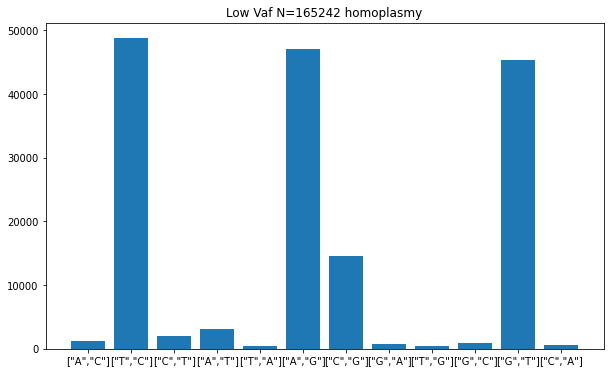

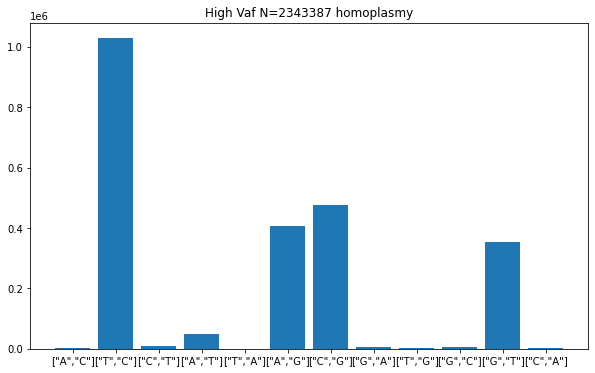

In [98]:
# homoplasmy
threshold = 0.001
top = 8 * 10**5
only_syn_helix_df_low_vaf = only_syn_helix_df[(only_syn_helix_df[['AF_hom']].sum(axis=1) <= threshold) & (only_syn_helix_df[['AF_hom']].sum(axis=1) > 0.00005)]
subs_number = only_syn_helix_df_low_vaf.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom']].sum(axis=1)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'Low Vaf N={subs_number.sum()} homoplasmy')
# plt.ylim(top=top)
plt.show()

only_syn_helix_df_high_vaf = only_syn_helix_df[(only_syn_helix_df[['AF_hom']].sum(axis=1) > threshold) & (only_syn_helix_df[['AF_hom']].sum(axis=1) > 0.00005)]
subs_number = only_syn_helix_df_high_vaf.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom']].sum(axis=1)
if len(subs_number) < 12:
    for sub in substitutions:
        if sub not in subs_number:
            subs_number[sub] = 0
    subs_number.sort_index(inplace=True)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'High Vaf N={subs_number.sum()} homoplasmy')
# plt.ylim(top=top)
plt.show()

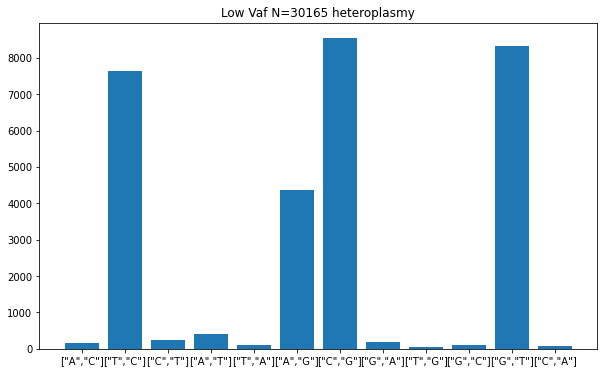

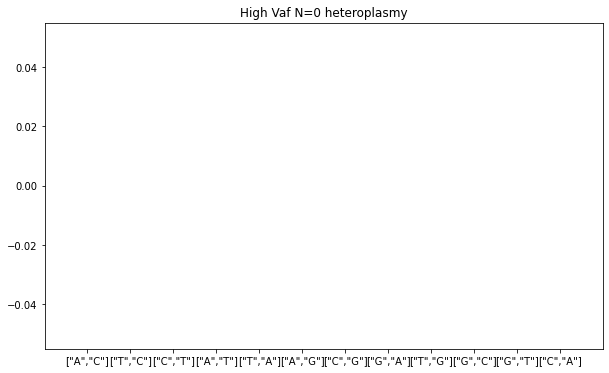

In [95]:
# heteroplamy
threshold = 0.1
top = 8 * 10**5
only_syn_helix_df_low_vaf = only_syn_helix_df[(only_syn_helix_df[['AF_het']].sum(axis=1) <= threshold) & (only_syn_helix_df[['AF_het']].sum(axis=1) > 0.000005)]
subs_number = only_syn_helix_df_low_vaf.groupby('alleles').sum(numeric_only=True).loc[:,['AC_het']].sum(axis=1)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'Low Vaf N={subs_number.sum()} heteroplasmy')
# plt.ylim(top=top)
plt.show()
only_syn_helix_df_high_vaf = only_syn_helix_df[(only_syn_helix_df[['AF_het']].sum(axis=1) > threshold) & (only_syn_helix_df[['AF_het']].sum(axis=1) > 0.000005)]
subs_number = only_syn_helix_df_high_vaf.groupby('alleles').sum(numeric_only=True).loc[:,['AC_het']].sum(axis=1)
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'High Vaf N={subs_number.sum()} heteroplasmy')
# plt.ylim(top=top)
plt.show()

## Threshold search

In [78]:
only_syn_helix_df_no_singletons = only_syn_helix_df[only_syn_helix_df.loc[:,['AC_hom', 'AC_het']].sum(axis=1) >= 1]
only_syn_helix_df_no_less_10 = only_syn_helix_df[only_syn_helix_df.loc[:,['AC_hom', 'AC_het']].sum(axis=1) >= 9]

In [30]:
def threshold_search_helix(helix_df, plasmy=['AC_hom', 'AC_het']):
    freq_array = sorted(helix_df.loc[:,['AF_hom', 'AF_het']].sum(axis=1).unique()[::150])
    # freq_array = np.logspace(-5, -1, 5)

    subs_freq_df = helix_df.loc[:,['AF_hom', 'AF_het']].sum(axis=1)
    for idx in range(len(freq_array)-1):
        threshold_lower = freq_array[idx] 
        threshold_upper = freq_array[idx+1]
        threshold_df = helix_df[(subs_freq_df >= threshold_lower) & (subs_freq_df < threshold_upper)]
        subs_number = threshold_df.groupby('alleles').sum(numeric_only=True).loc[:,plasmy].sum(axis=1)
        subs_number_sum = subs_number.sum()
        for sub in subs_number.index:
            subs_number[sub] /= helix_base_freq[sub[2]]
        subs_length_checker(subs_number, substitutions)
        plt.figure(figsize=(10,3))
        plt.bar(x=subs_number.index, height=subs_number)
        plt.title(f'Allele frequency {threshold_lower*100:.2}-{threshold_upper*100:.2}% plasmy: {[i[-3:] for i in plasmy]} N={subs_number_sum}')
        # plt.ylim(top=top)
        plt.show()

In [85]:
def threshold_search(only_syn_df, db_base_freq, db_samples_number, plasmy=['AC_hom', 'AC_het'], threshold_array = np.logspace(-6, -1, 6)):

    subs_freq_df = only_syn_df.loc[:,['AF_hom', 'AF_het']].sum(axis=1)
    for idx in range(len(threshold_array)-1):
        threshold_lower = threshold_array[idx] 
        threshold_upper = threshold_array[idx+1]
        threshold_df = only_syn_df[(subs_freq_df >= threshold_lower) & (subs_freq_df < threshold_upper)]
        subs_number = threshold_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,plasmy].sum(axis=1)
        subs_number_sum = subs_number.sum()
        for sub_idx in subs_number.index:
            subs_number[sub_idx] = subs_number[sub_idx] / db_samples_number #/ subs_number_sum / db_base_freq[sub_idx[0]]
        subs_length_checker(subs_number)
        plt.figure(figsize=(10,3))
        plt.bar(x=substitutions, height=subs_number)
        plt.title(f'Allele frequency {threshold_lower*100:.2}-{threshold_upper*100:.2}% plasmy: {[i[-3:] for i in plasmy]} N={subs_number_sum}')
        # plt.ylim(top=top)
        plt.show()

In [38]:
only_syn_helix_df.groupby(['ref', 'alt']).sum(numeric_only=True)

position   AC_hom    AF_hom  AC_het    AF_het    mean_ARF     max_ARF
ref alt                                                                       
A   C     3412693     3455  0.017629     169  0.000862   45.671383   49.008926
    G    21063319  1079865  5.509993    7637  0.038968  636.430253  901.503021
    T     4578147    11403  0.058184     236  0.001204   57.951514   59.883586
C   A     6791992    54544  0.278310     399  0.002036  102.091393  108.212961
    G     1793973     1161  0.005924      97  0.000495   17.693052   17.777779
    T    23173114   457828  2.336060    4353  0.022211  665.337418  848.358526
G   A     6413012   490890  2.504758    8539  0.043570  206.710626  389.597624
    C     1806466     7135  0.036406     174  0.000888   34.400951   40.382671
    T      997629     1763  0.008996      54  0.000276   14.329052   14.910992
T   A     2106036     7967  0.040651      92  0.000469   32.732904   33.398804
    C    14571681   401352  2.047892    8326  0.042483  475.273802  789.628988
    G     1937185     2478  0.012644      89  0.000454   26.299285   27.594925

In [39]:
only_syn_gnomad_df.groupby(['ref', 'alt']).sum(numeric_only=True)

position  AC_hom  AC_het    AF_hom    AF_het         AN  \
ref alt                                                            
A   C     3597604    1209      39  0.021424  0.000691   20763008   
    G    22621763  373295    1737  6.632146  0.030798  129666980   
    T     3478765    3688      42  0.065355  0.000744   20033878   
C   A     5500417   15889      71  0.281597  0.001258   31320479   
    G     1312887     376      13  0.006663  0.000230    6884852   
    T    24147943  205425     985  3.750883  0.017464  136328181   
G   A    10874026  191293    2202  3.397639  0.039048   63687884   
    C     2419600    3672      51  0.065080  0.000904   14672344   
    T      749108     458      15  0.008116  0.000266    4458179   
T   A     2233797    5076      24  0.089960  0.000425   13148555   
    C    22910605  172410    2302  3.058718  0.040802  132205252   
    G     2265008     676      24  0.012035  0.000425   12751623   

         max_observed_heteroplasmy  
ref alt                             
A   C                      152.622  
    G                     1718.797  
    T                      219.148  
C   A                      369.131  
    G                       75.977  
    T                     1956.689  
G   A                      484.130  
    C                       90.152  
    T                       33.922  
T   A                      109.290  
    C                     1091.717  
    G                       95.881

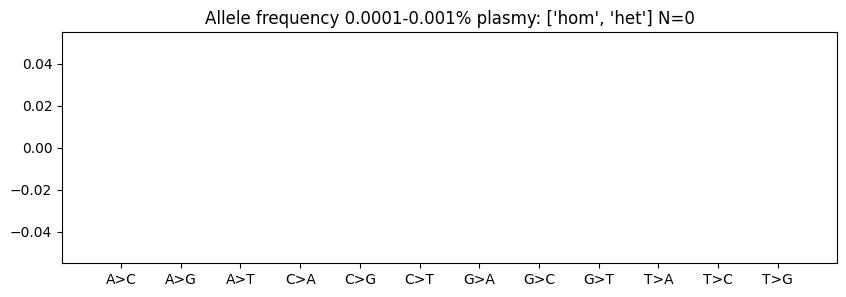

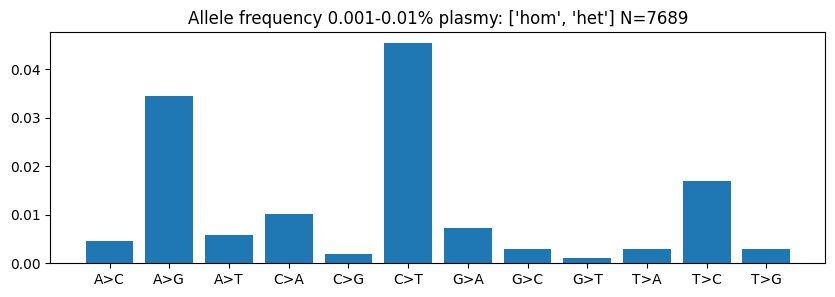

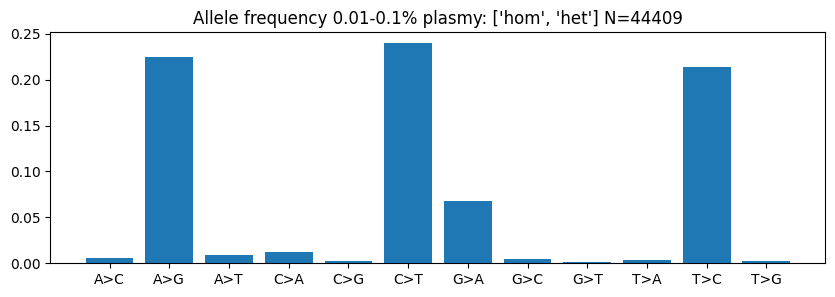

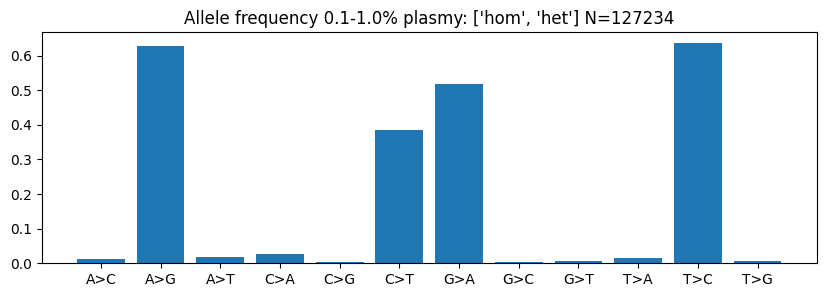

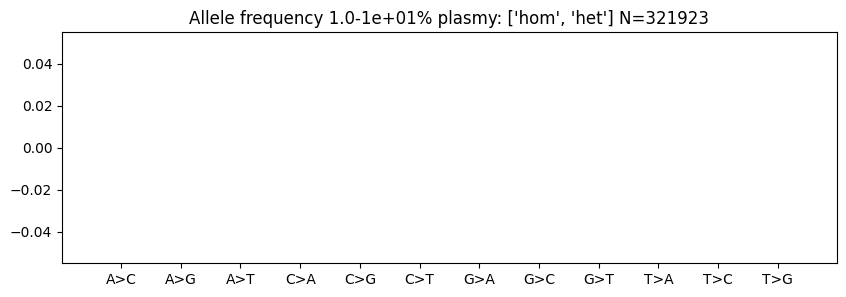

In [86]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_gnomad_df, gnomad_base_freq, gnomad_samples_number)

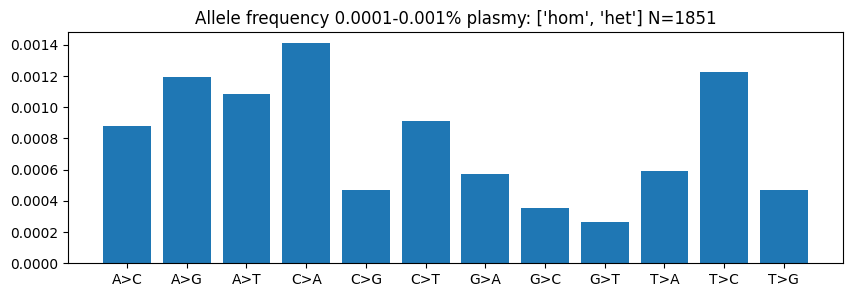

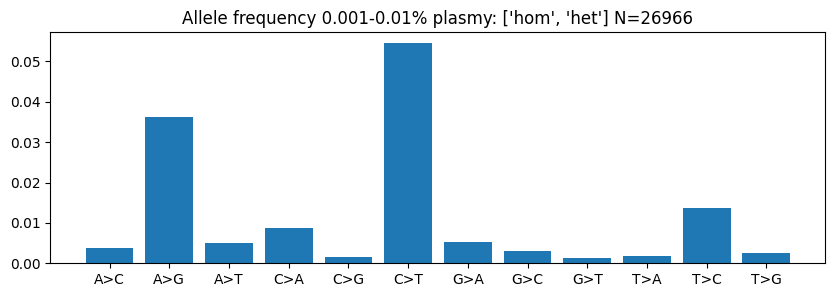

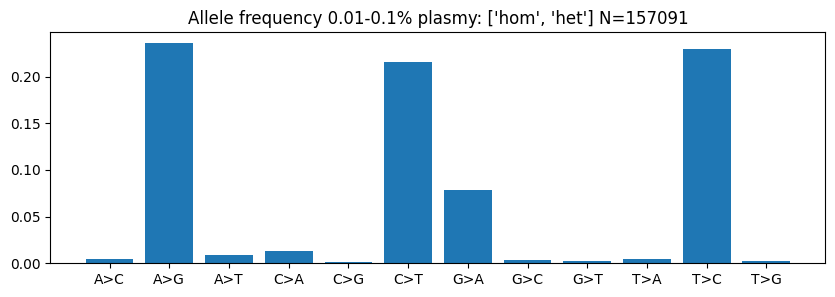

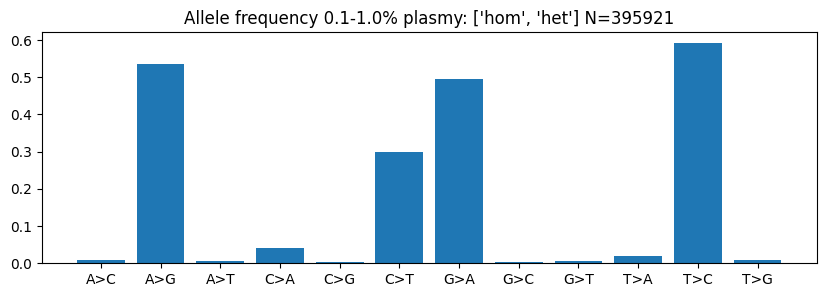

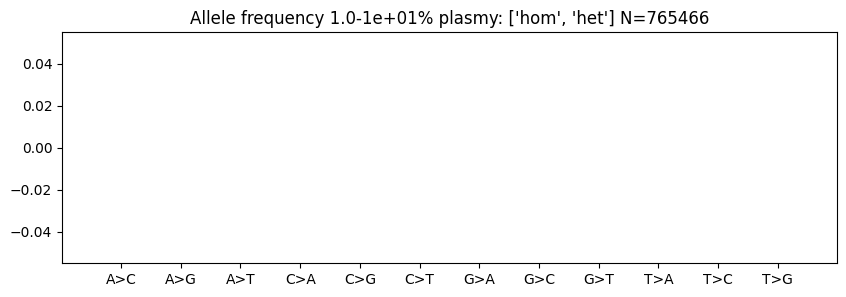

In [87]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_helix_df, helix_base_freq, helix_samples_number)

### No singletons

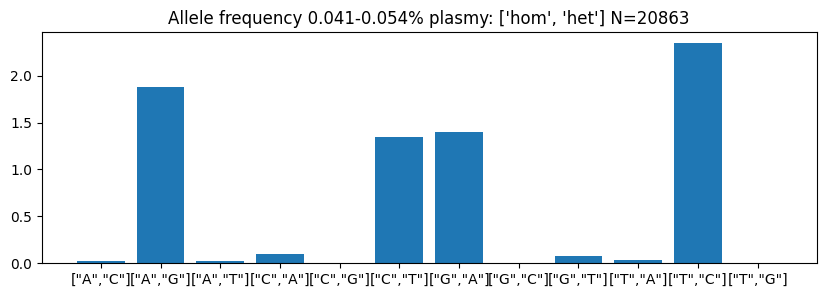

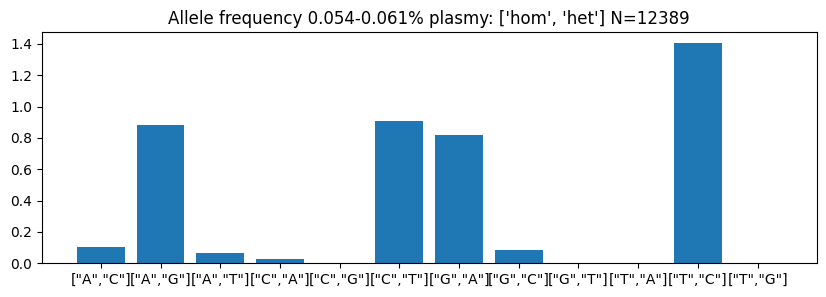

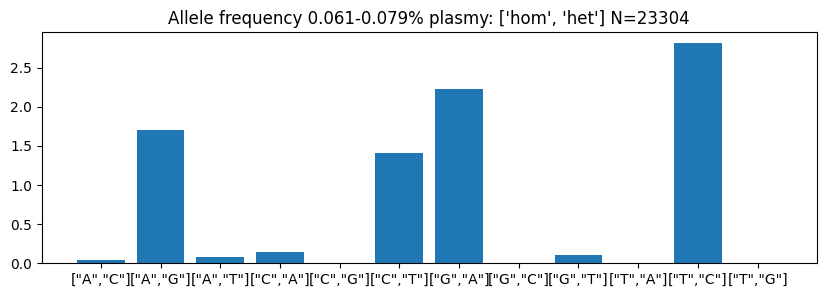

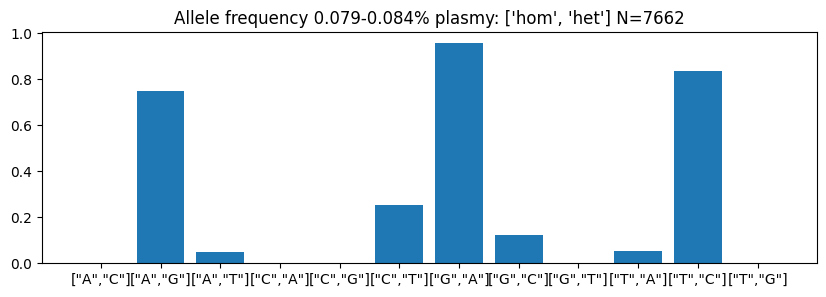

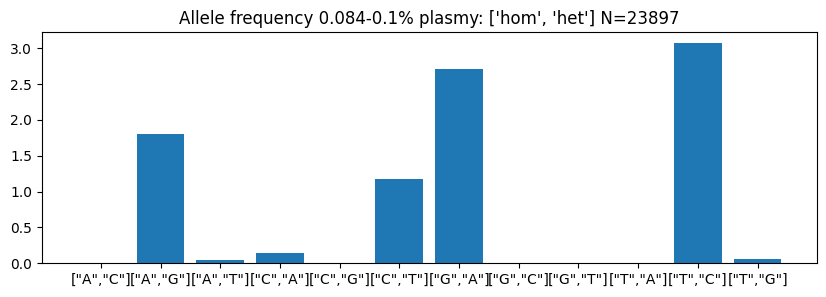

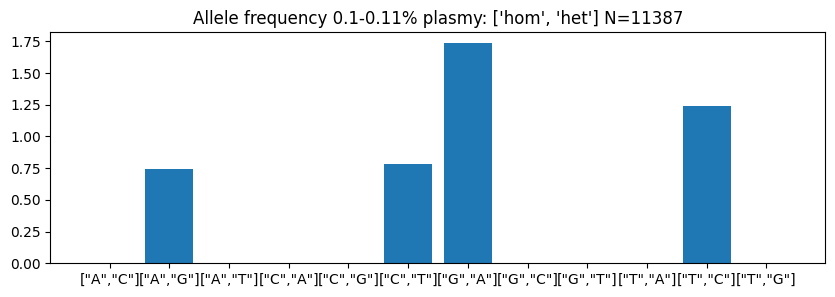

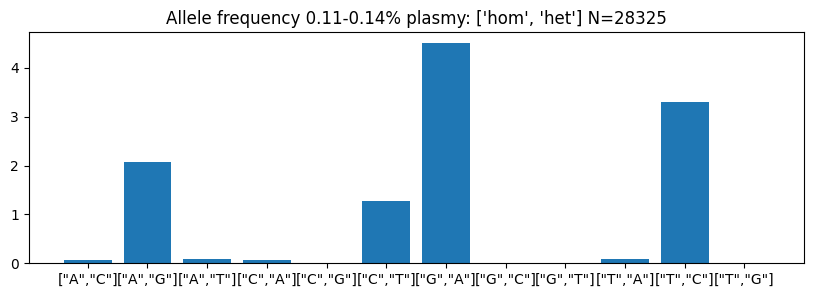

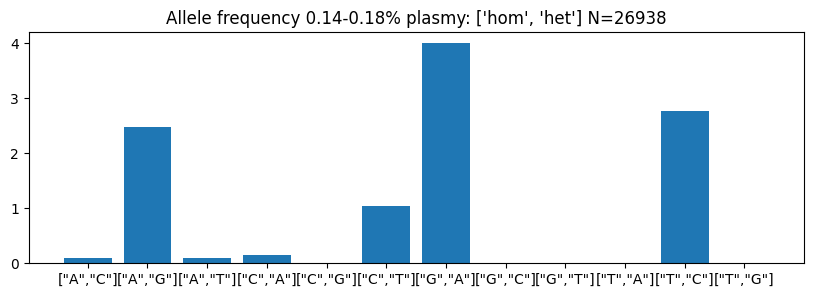

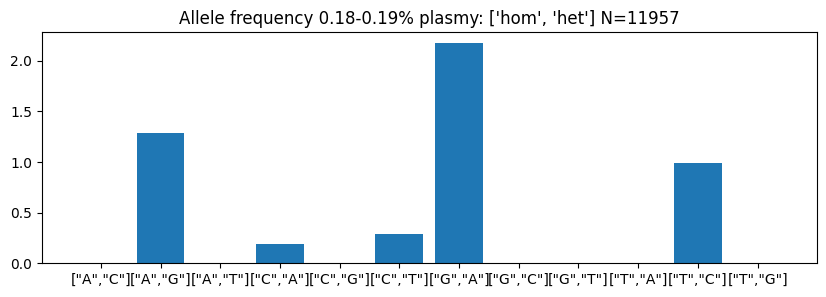

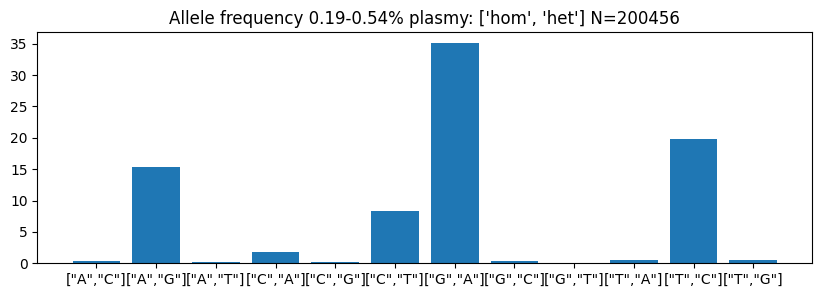

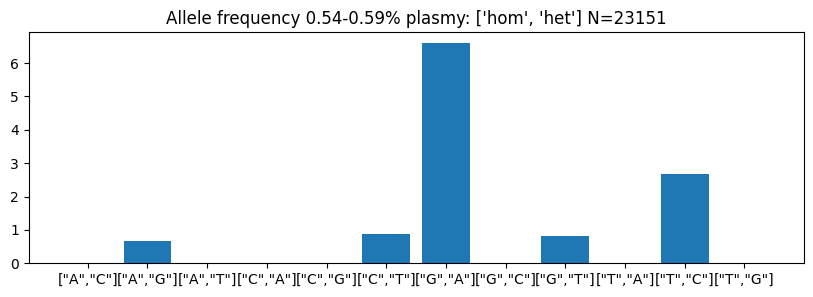

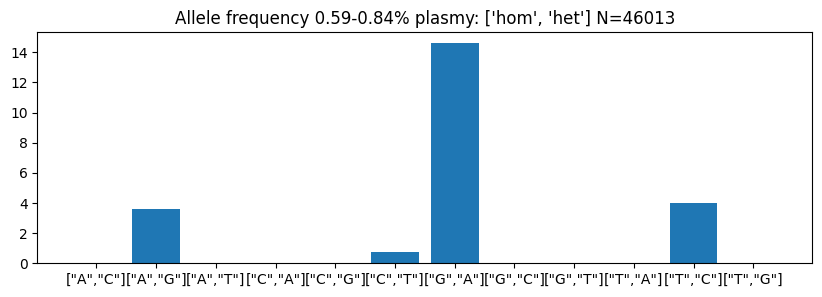

In [159]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search_helix(only_syn_helix_df_no_singletons)

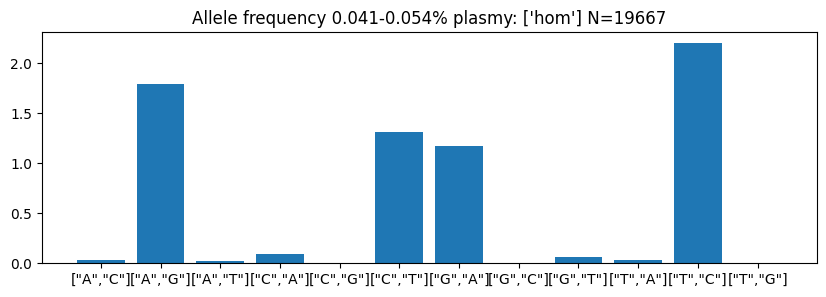

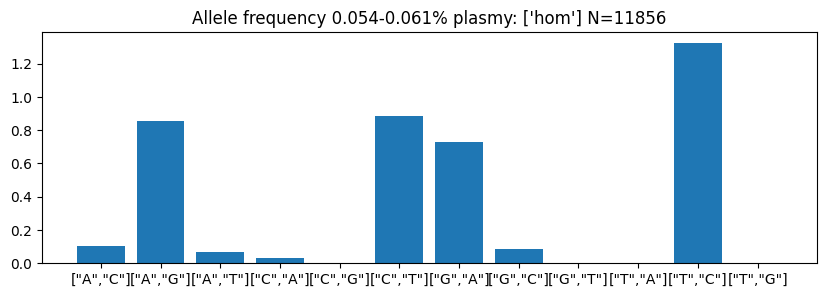

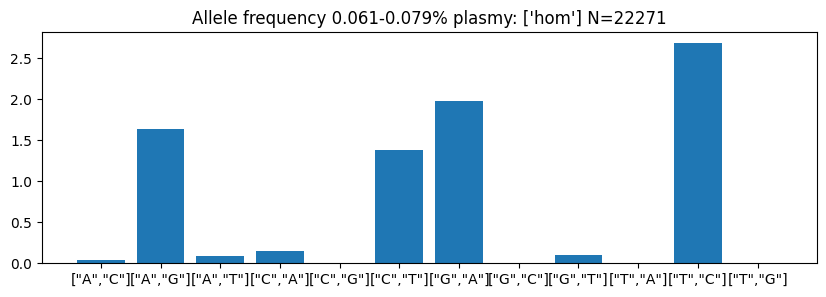

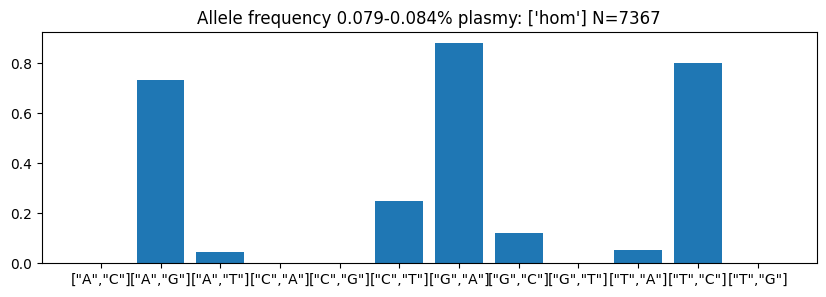

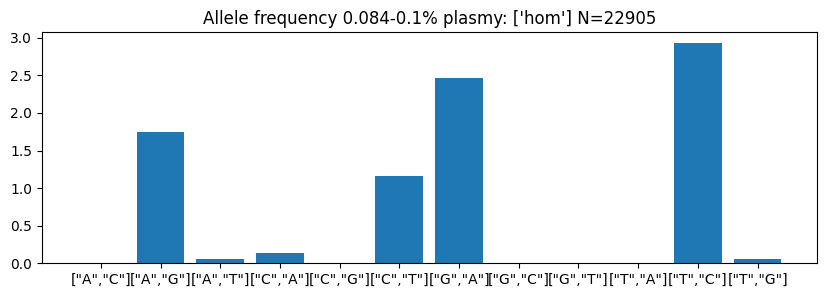

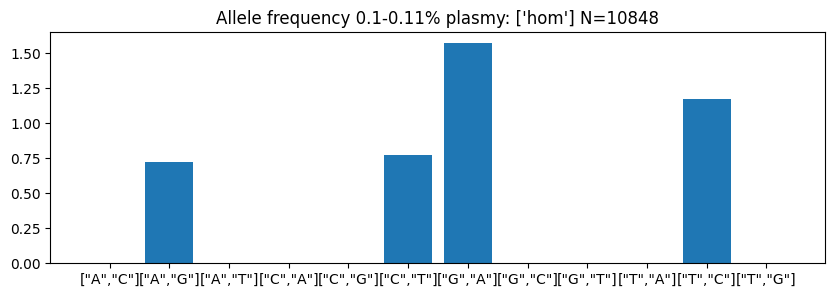

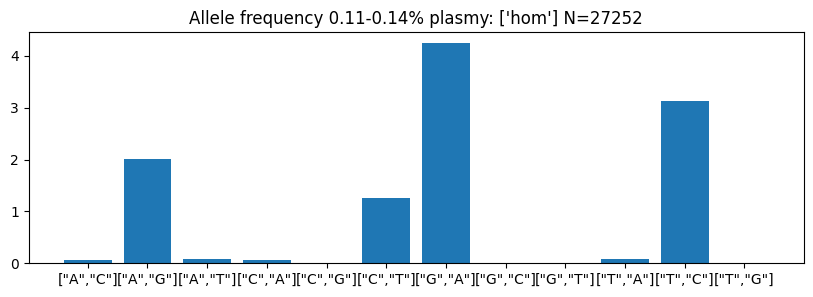

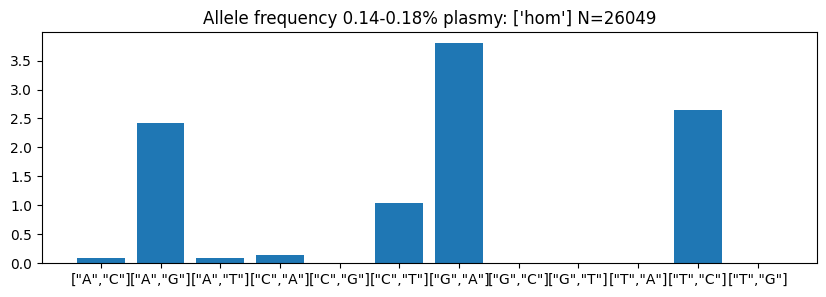

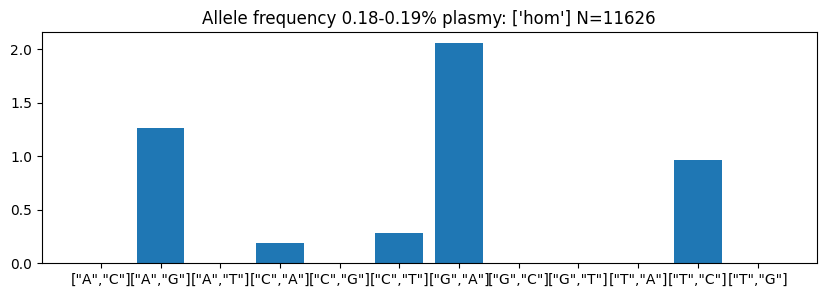

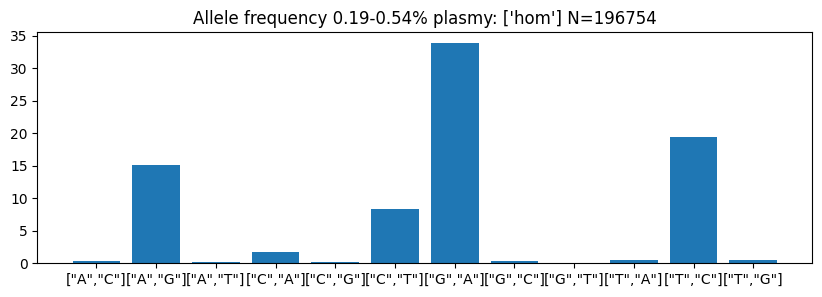

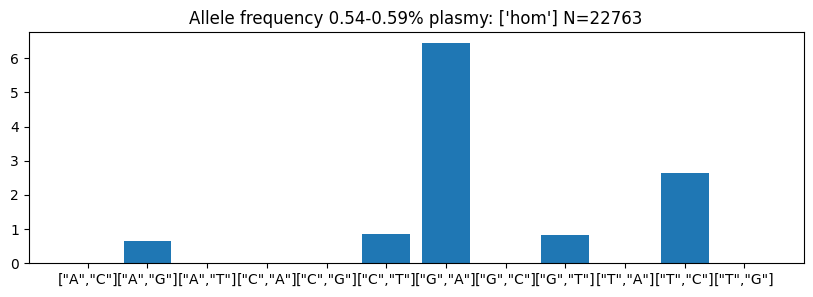

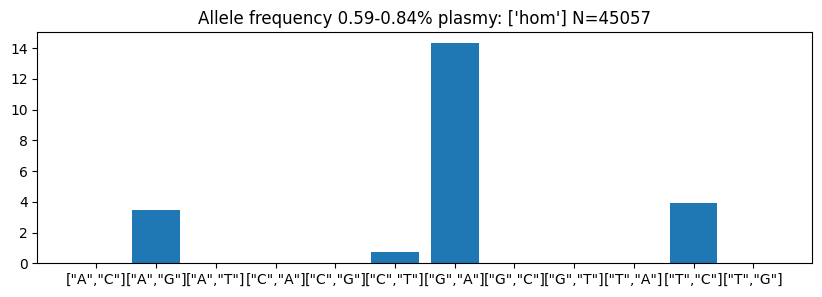

In [131]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search_helix(only_syn_helix_df_no_singletons, plasmy=['AC_hom'])

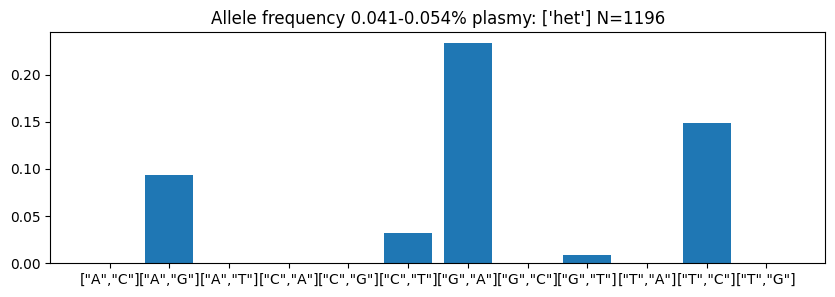

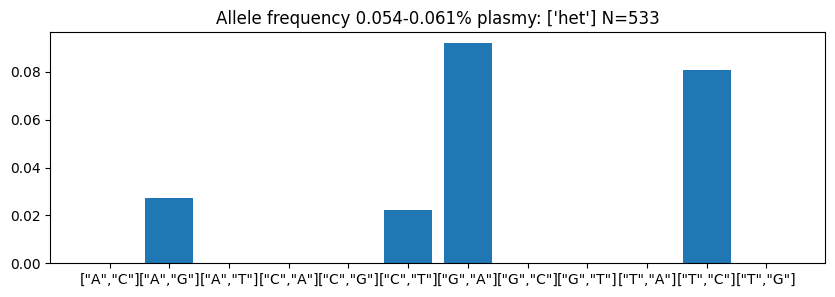

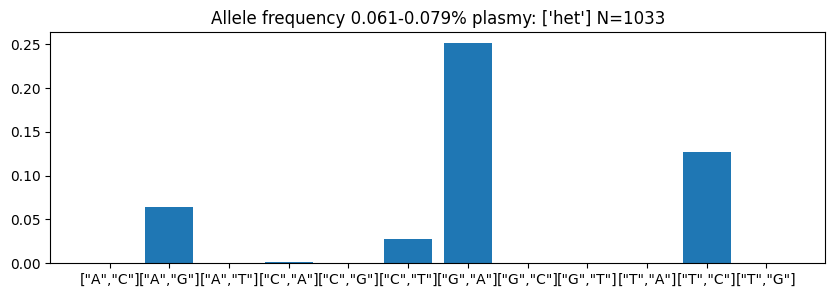

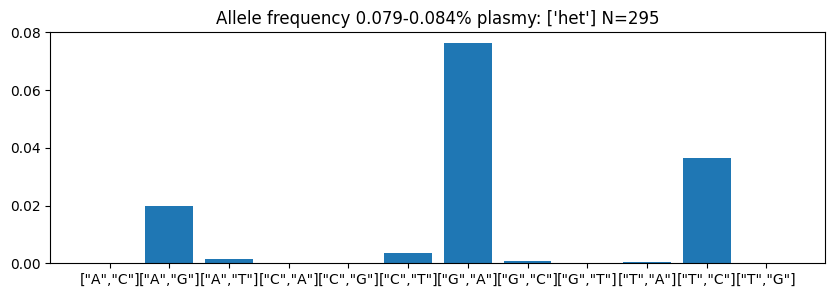

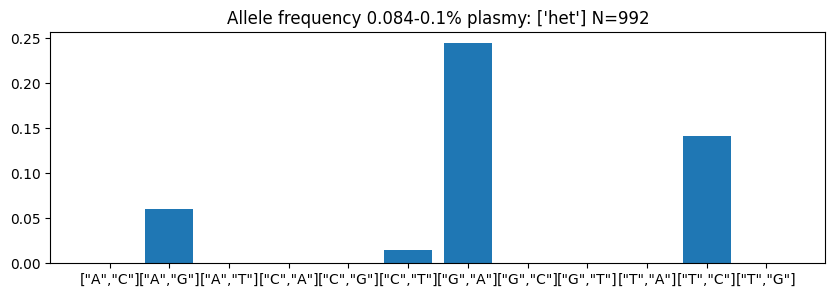

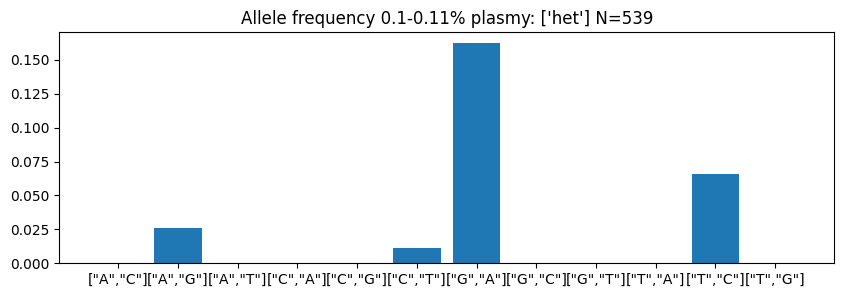

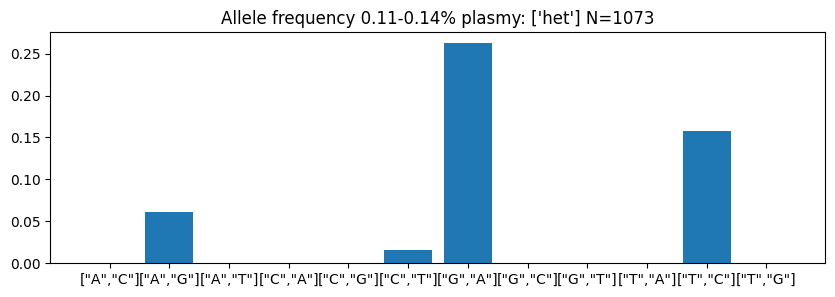

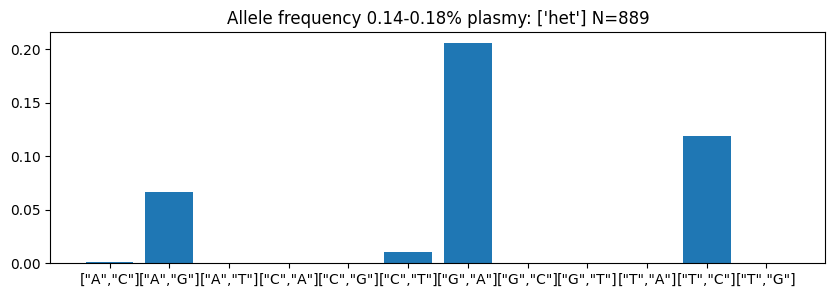

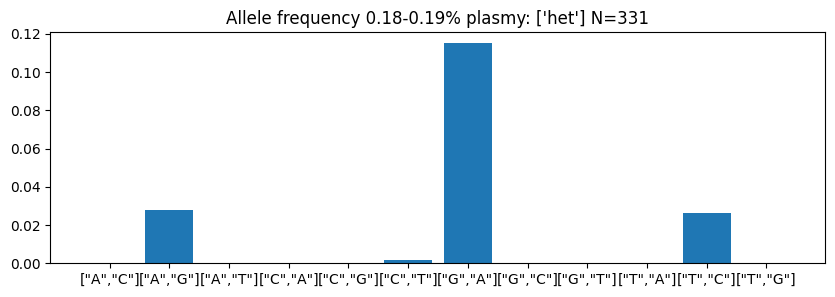

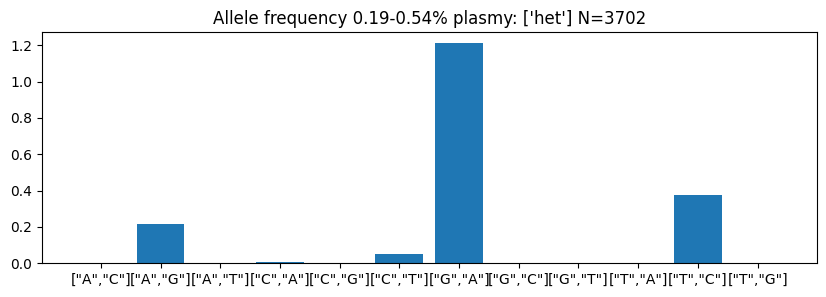

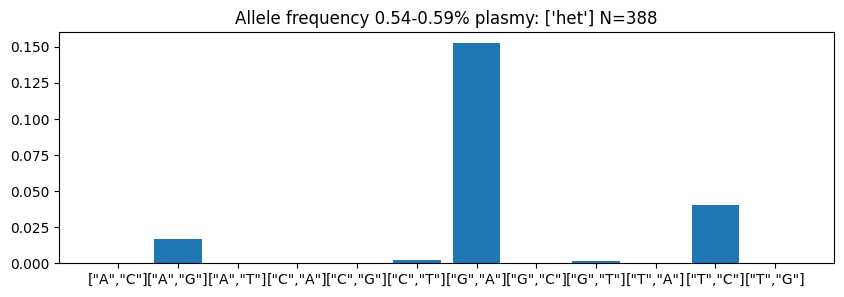

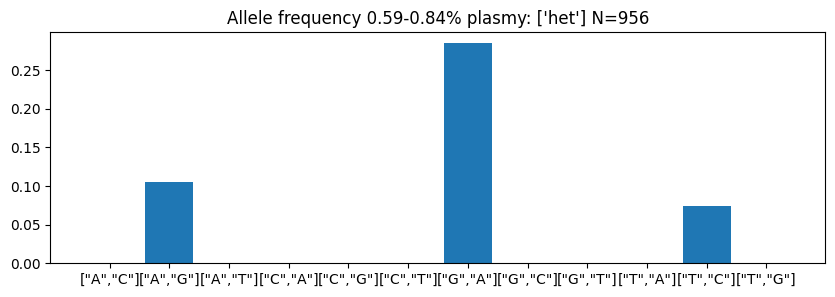

In [132]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_helix_df_no_singletons, plasmy=['AC_het'])

### No less than 10

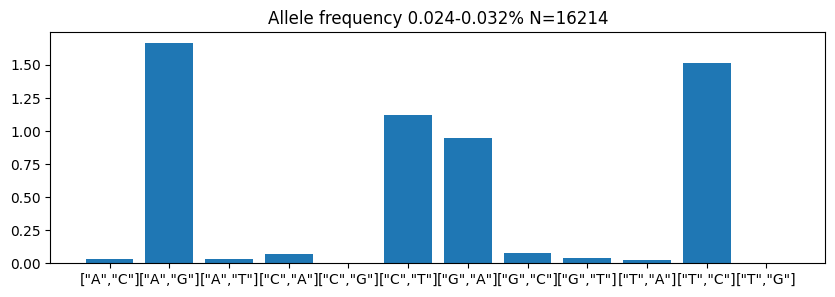

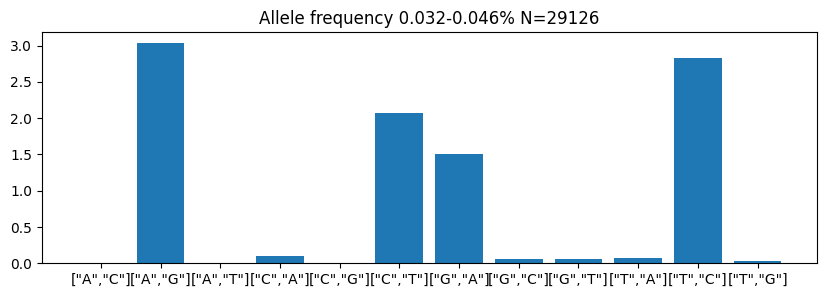

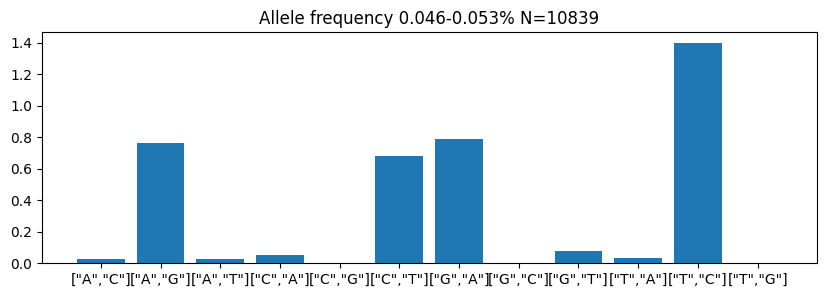

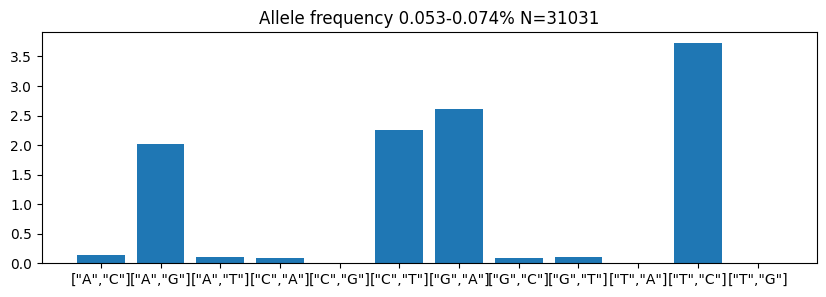

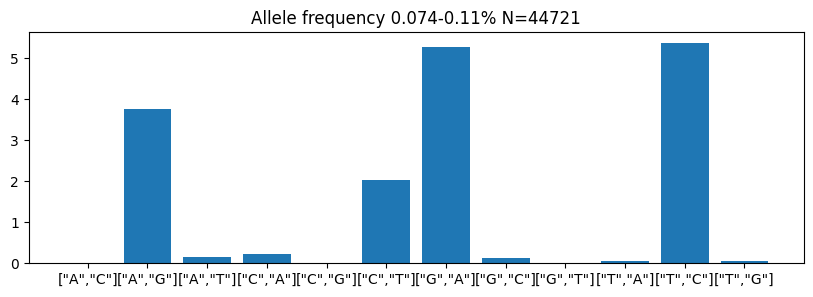

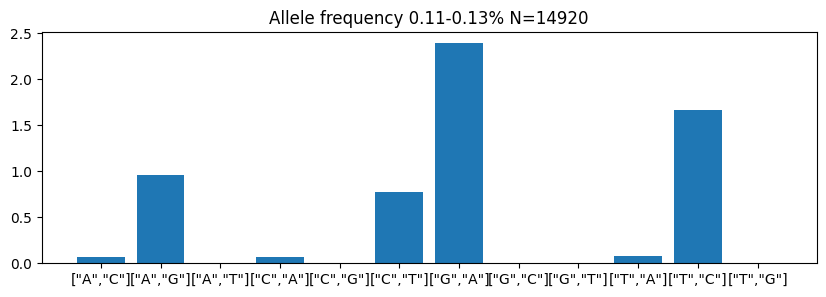

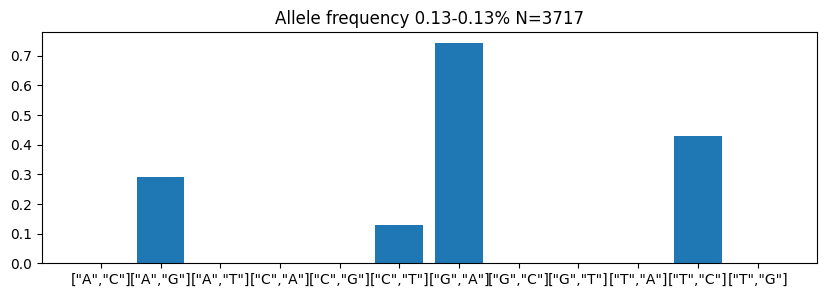

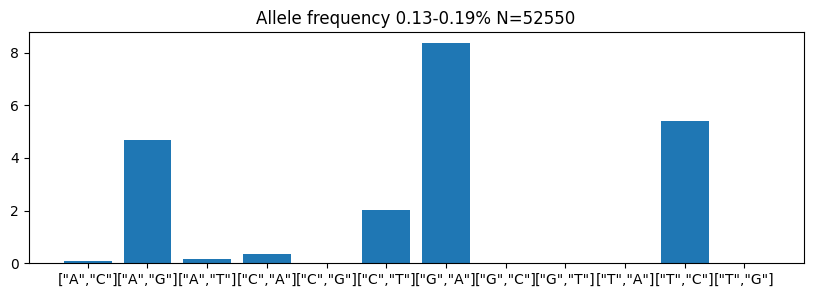

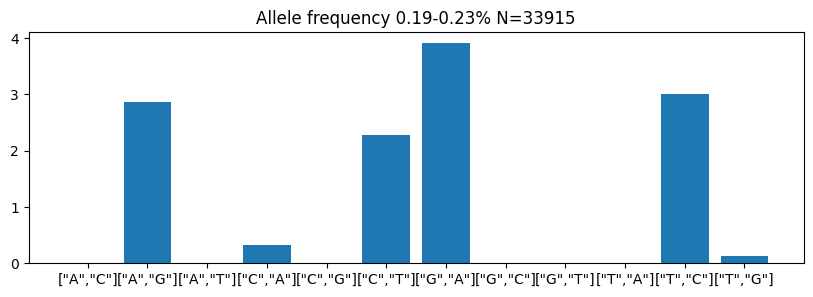

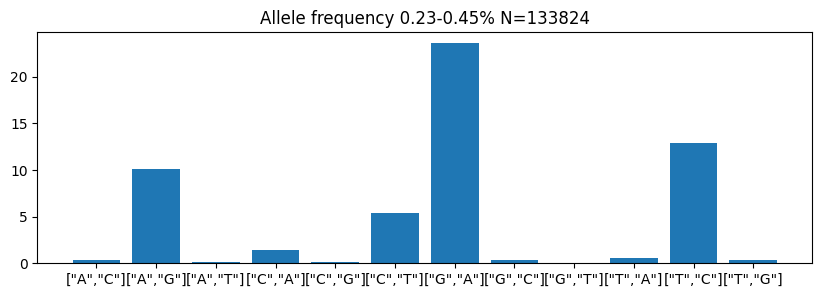

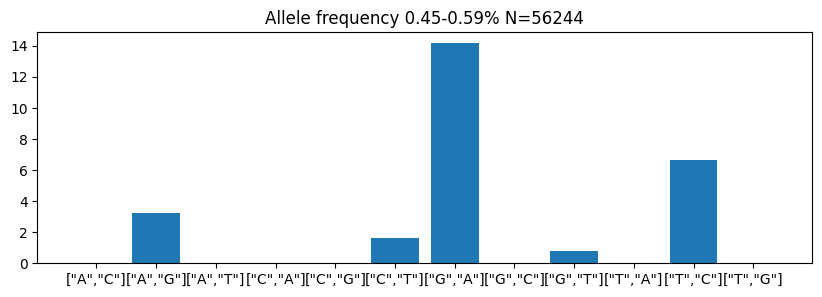

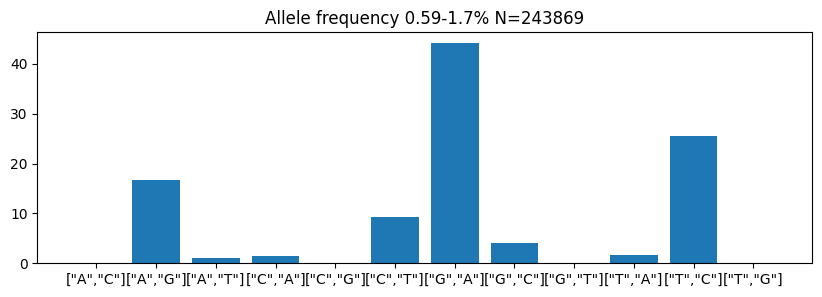

In [126]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_helix_df_no_less_10)

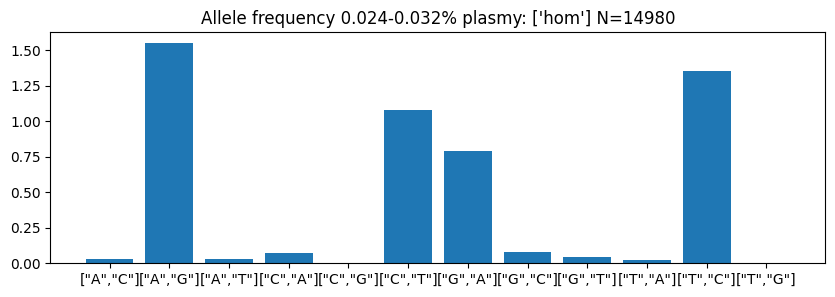

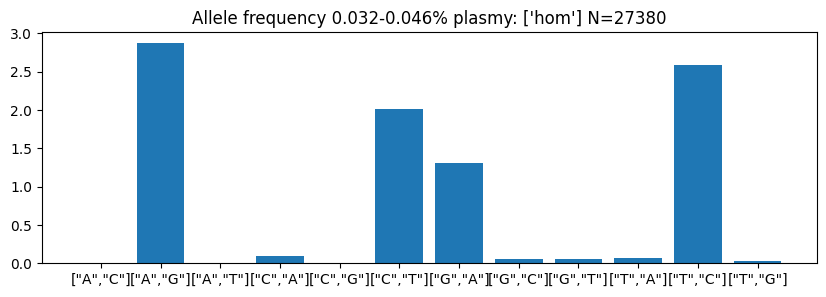

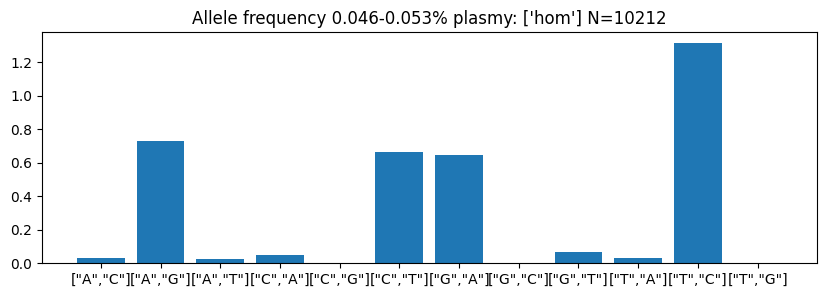

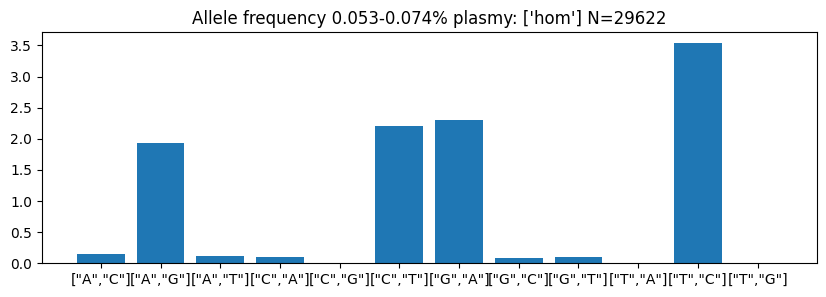

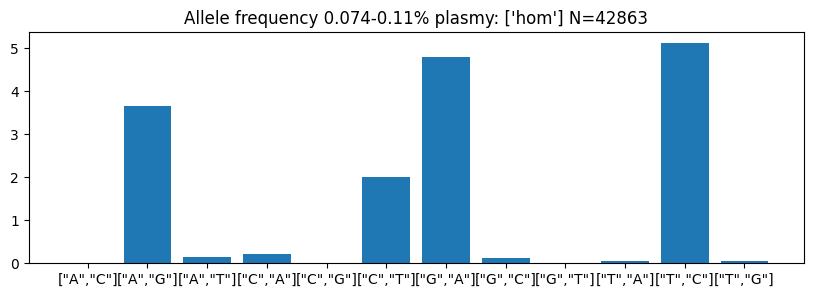

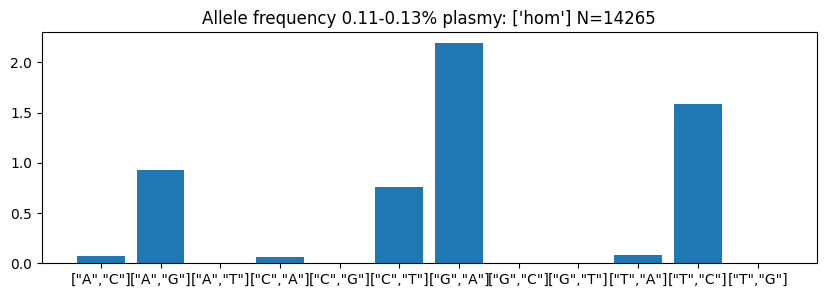

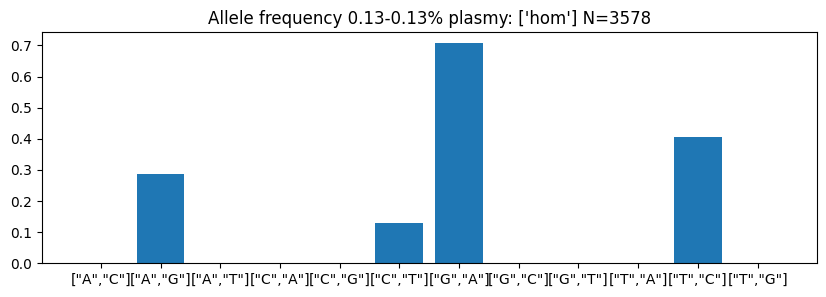

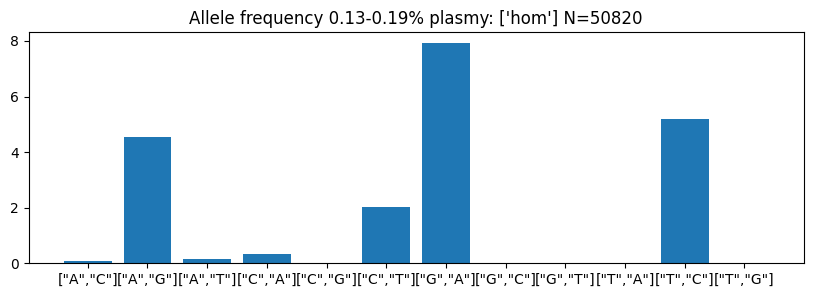

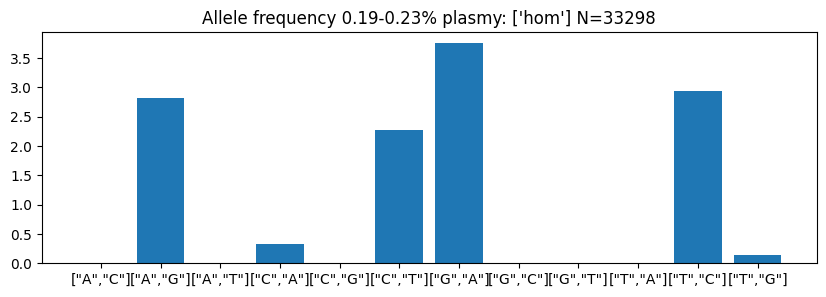

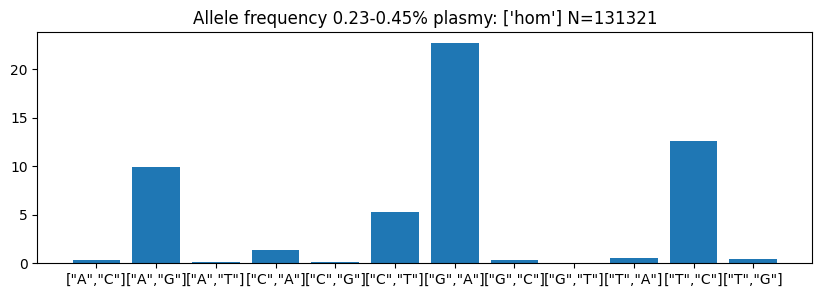

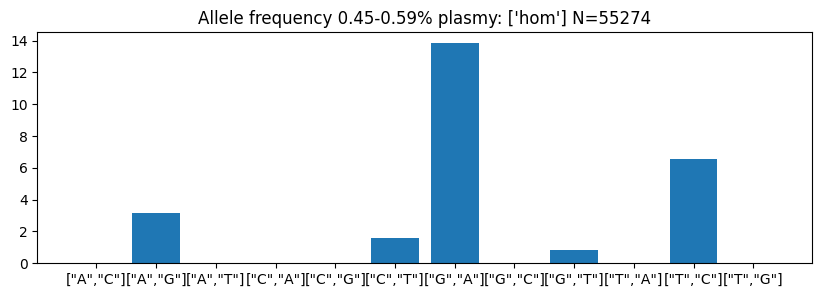

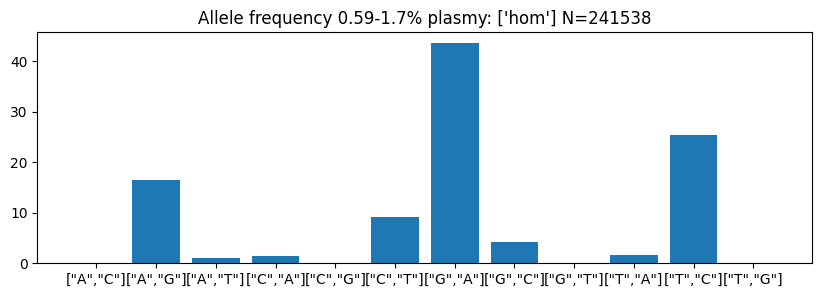

In [135]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_helix_df_no_less_10, plasmy=['AC_hom'])

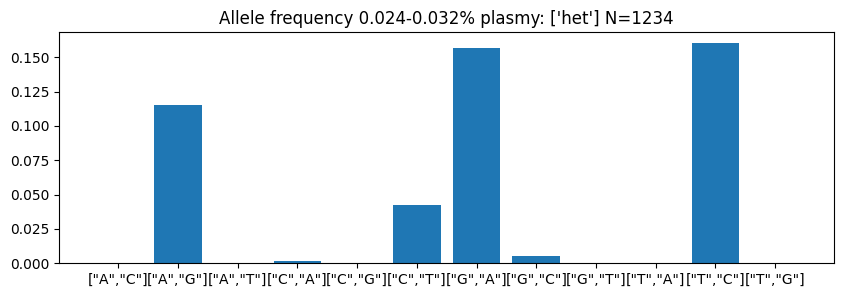

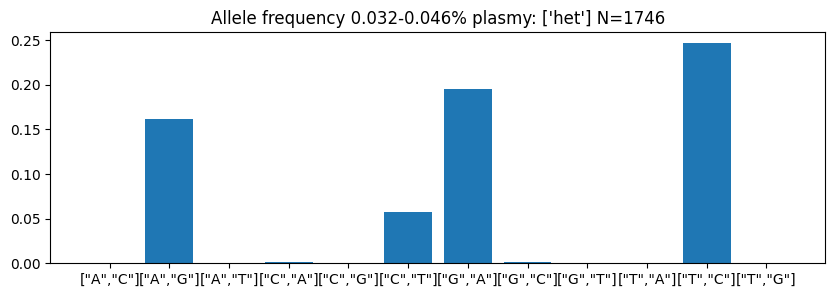

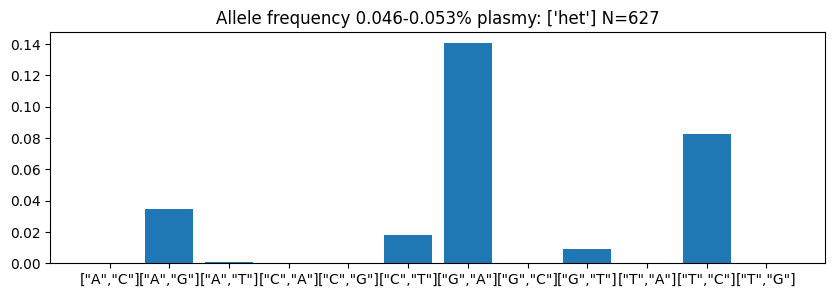

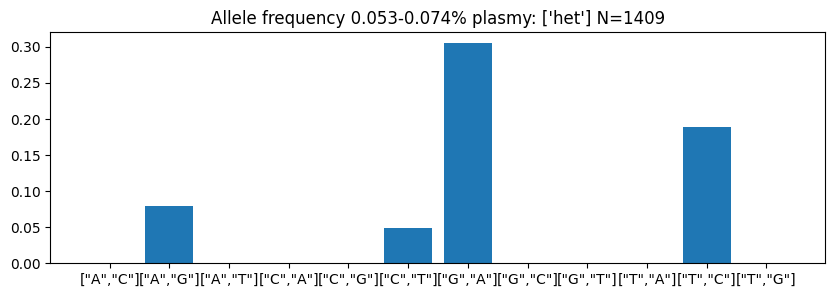

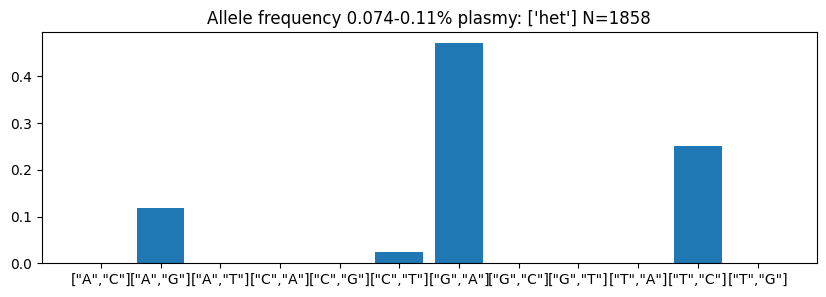

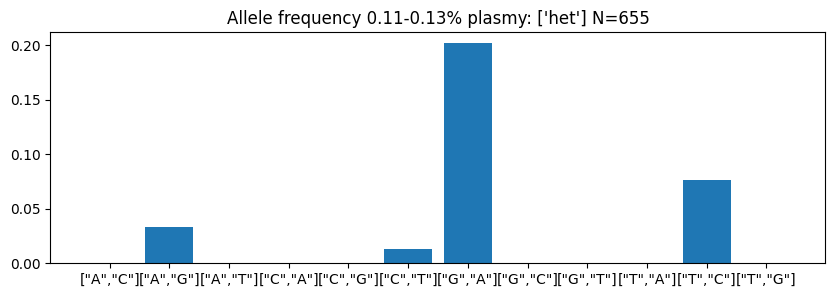

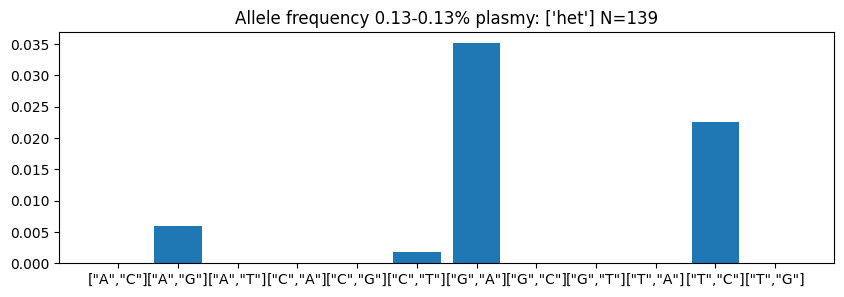

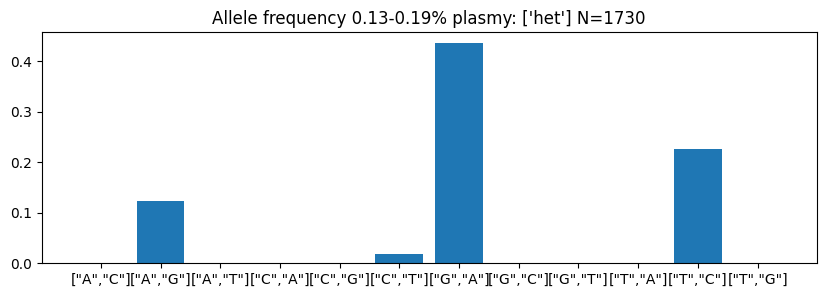

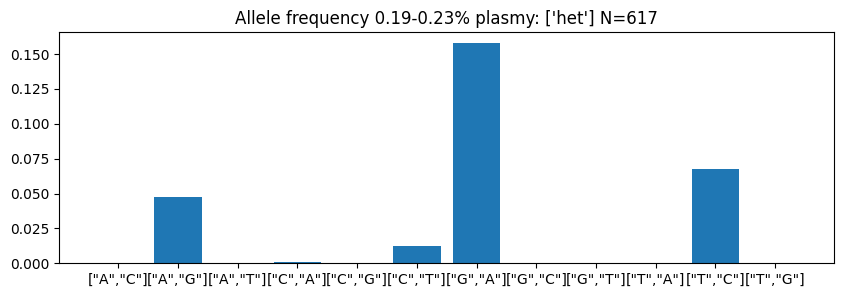

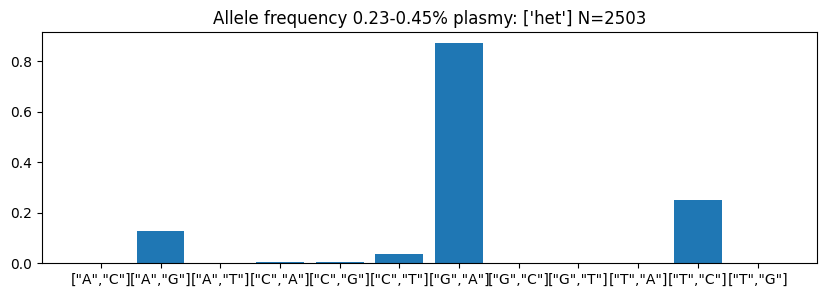

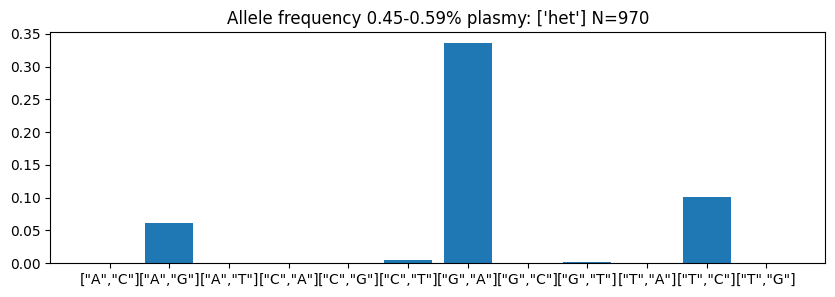

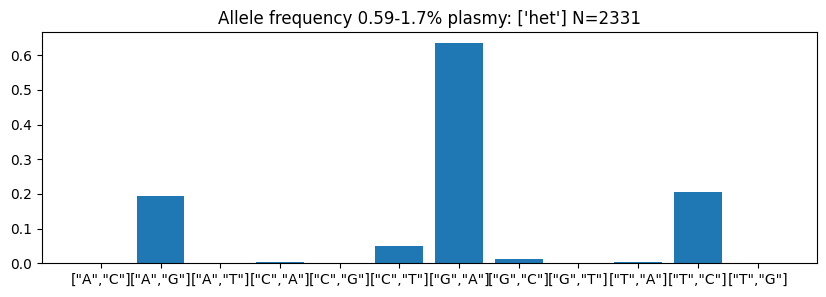

In [134]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_helix_df_no_less_10, plasmy=['AC_het'])

# gnomAD

In [17]:
gnomad_samples_number = 56434
gnomad_hchain_df = pd.read_csv(r'C:\Work\Lab\pr-29-trna-or-mutagenesis\raw\gnomad.genomes.v3.1.sites.chrM.reduced_annotations.tsv', sep='\t').copy()
gnomad_hchain_df

,chromosome,position,ref,alt,filters,AC_hom,AC_het,AF_hom,AF_het,AN,max_observed_heteroplasmy
0,chrM,3,T,C,PASS,19,1,0.000337,0.000018,56434,0.997
1,chrM,6,C,CCTCAA,npg,0,0,0.000000,0.000000,56433,0.000
2,chrM,7,A,G,npg,0,0,0.000000,0.000000,56433,0.000
3,chrM,8,G,T,PASS,5,0,0.000089,0.000000,56434,0.999
4,chrM,9,G,A,PASS,15,0,0.000266,0.000000,56434,0.993
...,...,...,...,...,...,...,...,...,...,...,...
18159,chrM,16548,C,A,npg,0,0,0.000000,0.000000,56433,0.000
18160,chrM,16558,G,A,PASS,1,0,0.000018,0.000000,56434,0.994
18161,chrM,16559,A,G,PASS,3,0,0.000053,0.000000,56433,0.997
18162,chrM,16560,C,T,PASS,1,0,0.000018,0.000000,56434,0.976


In [18]:
# moving to light chain
gnomad_df = gnomad_hchain_df.copy()
# ref_lchain = [str(Seq(ref).complement()) for ref in gnomad_hchain_df.ref]
# alt_lchain = [str(Seq(ref).complement()) for ref in gnomad_hchain_df.alt]
# gnomad_df.ref = ref_lchain
# gnomad_df.alt = alt_lchain
gnomad_df

,chromosome,position,ref,alt,filters,AC_hom,AC_het,AF_hom,AF_het,AN,max_observed_heteroplasmy
0,chrM,3,T,C,PASS,19,1,0.000337,0.000018,56434,0.997
1,chrM,6,C,CCTCAA,npg,0,0,0.000000,0.000000,56433,0.000
2,chrM,7,A,G,npg,0,0,0.000000,0.000000,56433,0.000
3,chrM,8,G,T,PASS,5,0,0.000089,0.000000,56434,0.999
4,chrM,9,G,A,PASS,15,0,0.000266,0.000000,56434,0.993
...,...,...,...,...,...,...,...,...,...,...,...
18159,chrM,16548,C,A,npg,0,0,0.000000,0.000000,56433,0.000
18160,chrM,16558,G,A,PASS,1,0,0.000018,0.000000,56434,0.994
18161,chrM,16559,A,G,PASS,3,0,0.000053,0.000000,56433,0.997
18162,chrM,16560,C,T,PASS,1,0,0.000018,0.000000,56434,0.976


In [19]:
only_subs_gnomad_df = gnomad_df[((gnomad_df.ref.apply(len)) == 1) & ((gnomad_df.alt.apply(len) == 1))]
only_subs_gnomad_df

,chromosome,position,ref,alt,filters,AC_hom,AC_het,AF_hom,AF_het,AN,max_observed_heteroplasmy
0,chrM,3,T,C,PASS,19,1,0.000337,0.000018,56434,0.997
2,chrM,7,A,G,npg,0,0,0.000000,0.000000,56433,0.000
3,chrM,8,G,T,PASS,5,0,0.000089,0.000000,56434,0.999
4,chrM,9,G,A,PASS,15,0,0.000266,0.000000,56434,0.993
5,chrM,10,T,C,PASS,11,0,0.000195,0.000000,56434,0.993
...,...,...,...,...,...,...,...,...,...,...,...
18159,chrM,16548,C,A,npg,0,0,0.000000,0.000000,56433,0.000
18160,chrM,16558,G,A,PASS,1,0,0.000018,0.000000,56434,0.994
18161,chrM,16559,A,G,PASS,3,0,0.000053,0.000000,56433,0.997
18162,chrM,16560,C,T,PASS,1,0,0.000018,0.000000,56434,0.976


## RefSeq

In [25]:
refseq_gnomad = SeqIO.read(r"C:\Work\Lab\pr-29-trna-or-mutagenesis\raw\J01415.2.gb", "genbank")
# refseq_gnomad.seq = Seq(refseq_gnomad.seq).complement()  # It seems that this refseq is also on heavy chain as gnomad db


In [26]:
cds_gnomad = []
for refseq_gnomad_feature in refseq_gnomad.features:
    if refseq_gnomad_feature.type == 'CDS': #  ['source', 'D-loop', 'gene', 'misc_feature']
        cds_gnomad.append(refseq_gnomad_feature)
cds_gnomad

[SeqFeature(SimpleLocation(ExactPosition(3306), ExactPosition(4262), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(4469), ExactPosition(5511), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(5903), ExactPosition(7445), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(7585), ExactPosition(8269), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(8365), ExactPosition(8572), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(8526), ExactPosition(9207), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(9206), ExactPosition(9990), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(10058), ExactPosition(10404), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(10469), ExactPosition(10766), strand=1), type='CDS', qualifiers=...),
 SeqFeature(Sim

In [27]:
# checking of substitutioning and reference bases match
for position in only_subs_gnomad_df.position:
    initial_base = only_subs_gnomad_df.loc[only_subs_gnomad_df.position==position, 'ref'].iloc[0]
    reference_base = refseq_gnomad.seq[position-1]
    if initial_base != reference_base:
        print(position, initial_base, reference_base)

In [28]:
# extraction of only synonymous variants
only_syn_gnomad_df = syn_subs_extracter(only_subs_gnomad_df, cds_gnomad, refseq_gnomad)
only_syn_gnomad_df

c:\Soft\Python\Lib\site-packages\Bio\Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


,chromosome,position,ref,alt,filters,AC_hom,AC_het,AF_hom,AF_het,AN,max_observed_heteroplasmy
4306,chrM,3308,T,C,PASS,1609,5,0.028524,0.000089,56409,1.000
4311,chrM,3311,C,T,PASS,13,0,0.000230,0.000000,56433,0.999
4313,chrM,3314,T,C,npg,0,0,0.000000,0.000000,56433,0.000
4318,chrM,3317,C,T,PASS,2,0,0.000035,0.000000,56433,1.000
4323,chrM,3320,A,G,PASS,89,3,0.001577,0.000053,56430,1.000
...,...,...,...,...,...,...,...,...,...,...,...
17135,chrM,15884,G,C,PASS,825,0,0.014621,0.000000,56427,1.000
17136,chrM,15885,C,G,PASS,1,0,0.000018,0.000000,56434,0.982
17137,chrM,15885,C,T,PASS,26,2,0.000461,0.000035,56431,1.000
17138,chrM,15886,C,A,PASS,1,0,0.000018,0.000000,56434,0.987


In [29]:
# synonymous base usage
gnomad_base_freq = {base:0 for base in ['A', 'T', 'G', 'C']}
for cds in cds_gnomad:
    start = cds.location.start
    end = cds.location.end
    gene_df = only_subs_gnomad_df.loc[(only_subs_gnomad_df.position > start) & (only_subs_gnomad_df.position < end)]
    sequence = refseq_gnomad.seq[start-1:end-1]
    for base in ['A', 'T', 'G', 'C']:
        gnomad_base_freq[base] += sequence.count(base)
gnomad_base_freq

{'A': 3392, 'T': 2879, 'G': 1338, 'C': 3786}

## Synonymous subs

In [129]:
only_syn_gnomad_df.groupby(['ref', 'alt']).sum(numeric_only=True)

position  AC_hom  AC_het    AF_hom    AF_het         AN  \
ref alt                                                            
A   C     3597604    1209      39  0.021424  0.000691   20763008   
    G    22621763  373295    1737  6.632146  0.030798  129666980   
    T     3478765    3688      42  0.065355  0.000744   20033878   
C   A     5500417   15889      71  0.281597  0.001258   31320479   
    G     1312887     376      13  0.006663  0.000230    6884852   
    T    24147943  205425     985  3.750883  0.017464  136328181   
G   A    10874026  191293    2202  3.397639  0.039048   63687884   
    C     2419600    3672      51  0.065080  0.000904   14672344   
    T      749108     458      15  0.008116  0.000266    4458179   
T   A     2233797    5076      24  0.089960  0.000425   13148555   
    C    22910605  172410    2302  3.058718  0.040802  132205252   
    G     2265008     676      24  0.012035  0.000425   12751623   

         max_observed_heteroplasmy  
ref alt                             
A   C                      152.622  
    G                     1718.797  
    T                      219.148  
C   A                      369.131  
    G                       75.977  
    T                     1956.689  
G   A                      484.130  
    C                       90.152  
    T                       33.922  
T   A                      109.290  
    C                     1091.717  
    G                       95.881

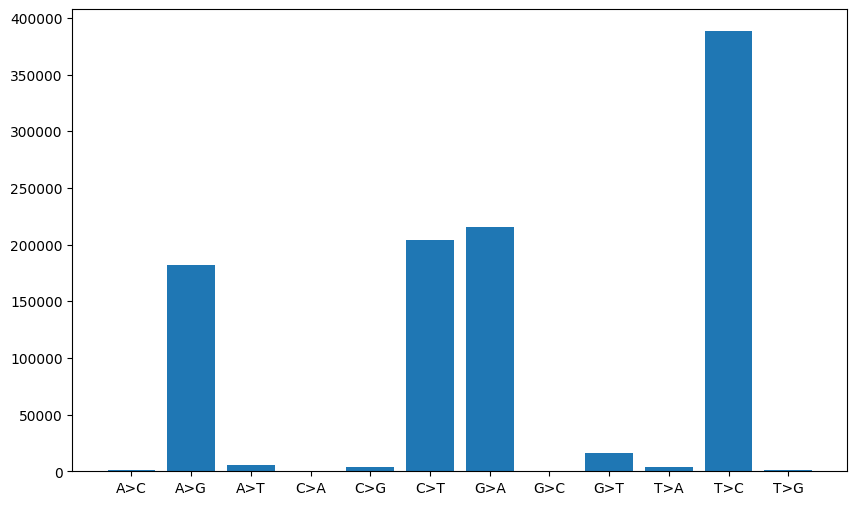

In [68]:
subs_number = only_syn_gnomad_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.show()

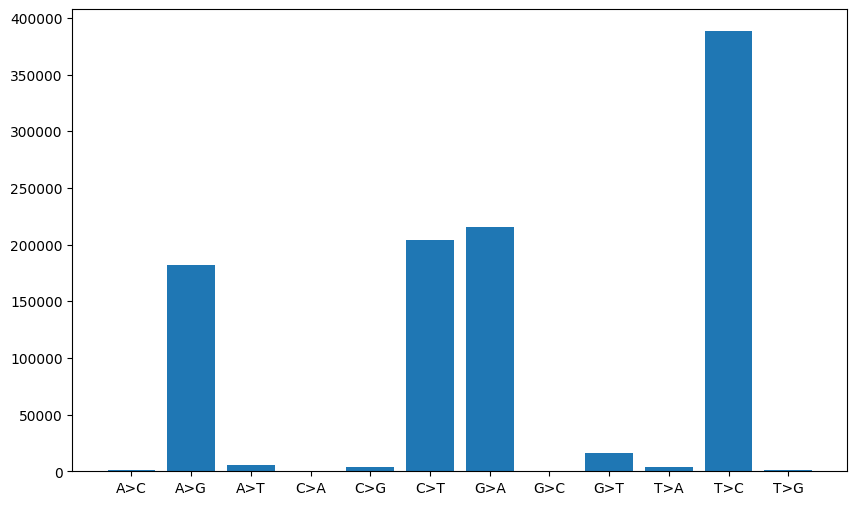

In [67]:
subs_number = only_syn_gnomad_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
plt.figure(figsize=(10,6))
plt.bar(x=[f'{idx[0]}>{idx[1]}' for idx in subs_number.index], height=subs_number)
plt.show()

In [125]:
np.logspace(-5, -3, 5)
# np.linspace(1e-5,)

array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03])

In [75]:
def threshold_search_gnomad(gnomad_df, plasmy=['AC_hom', 'AC_het']):
    # freq_array = sorted(gnomad_df.loc[:,['AF_hom', 'AF_het']].sum(axis=1).unique()[::150])
    freq_array = np.logspace(-6, -1, 6)
    
    subs_freq_df = gnomad_df.loc[:,['AF_hom', 'AF_het']].sum(axis=1)
    for idx in range(len(freq_array)-1):
        threshold_lower = freq_array[idx] 
        threshold_upper = freq_array[idx+1]
        threshold_df = gnomad_df[(subs_freq_df >= threshold_lower) & (subs_freq_df < threshold_upper)]
        # if len(threshold_df) < 1:
        #     continue
        subs_number = threshold_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,plasmy].sum(axis=1)
        subs_length_checker(subs_number)
        subs_number_sum = subs_number.sum()
        for sub in subs_number.index:
            subs_number[sub] /= gnomad_base_freq[sub[1]] / 56434 / subs_number_sum
        
        plt.figure(figsize=(10,3))
        plt.bar(x=substitutions, height=subs_number)
        plt.title(f'Allele frequency {threshold_lower*100:.2}-{threshold_upper*100:.2}% plasmy: {[i[-3:] for i in plasmy]} N={subs_number_sum}')
        # plt.ylim(top=top)
        plt.show()

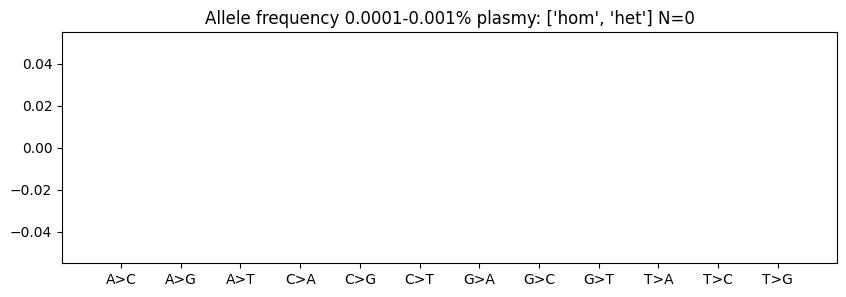

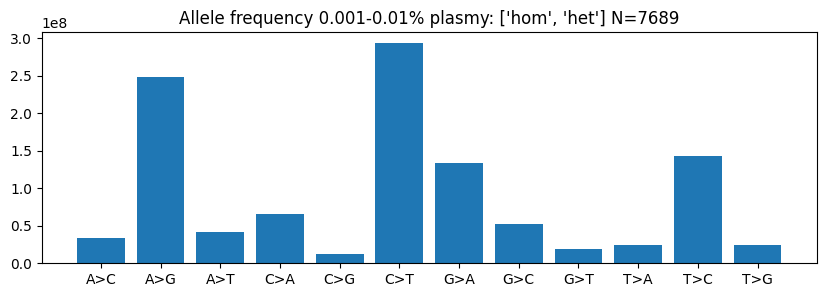

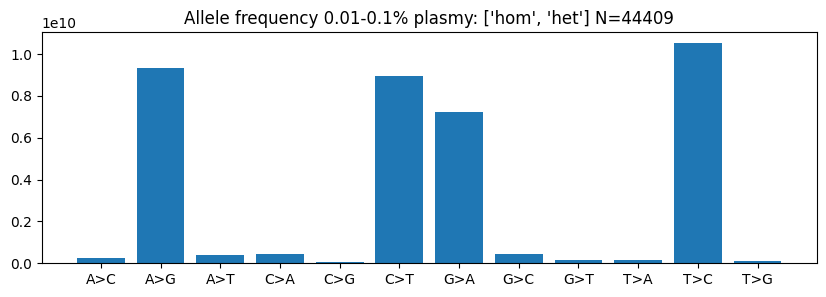

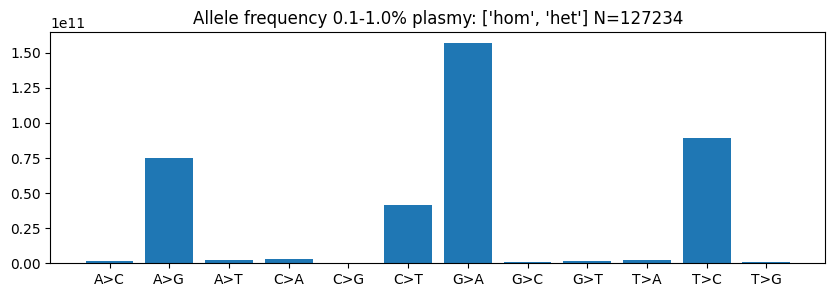

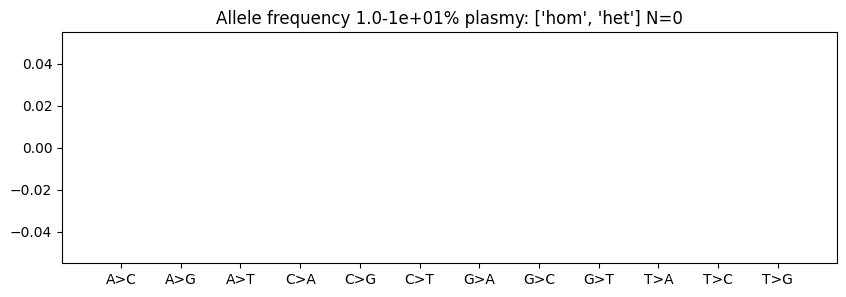

In [76]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search_gnomad(only_syn_gnomad_df)

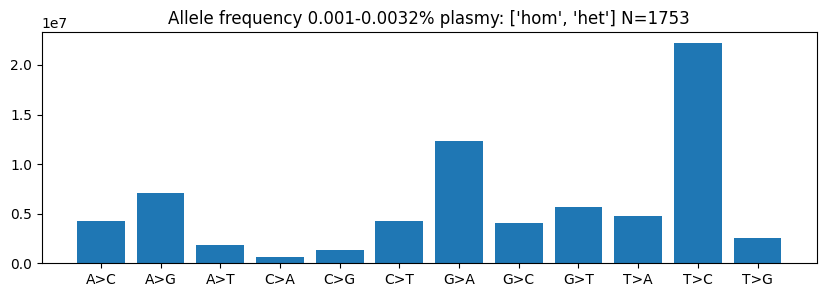

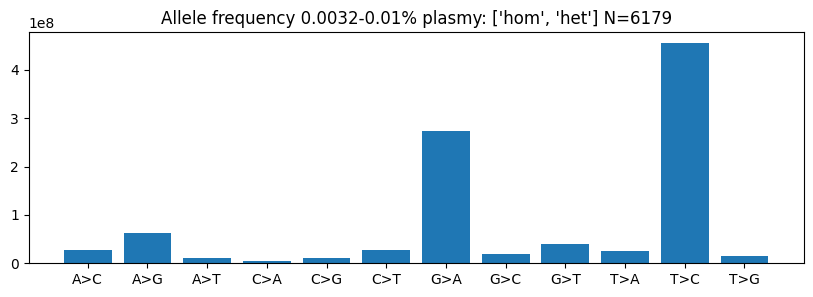

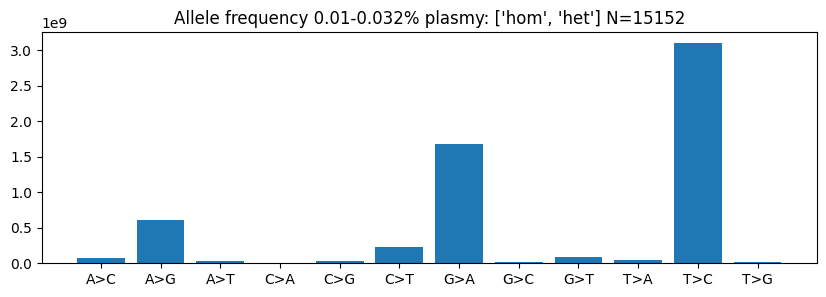

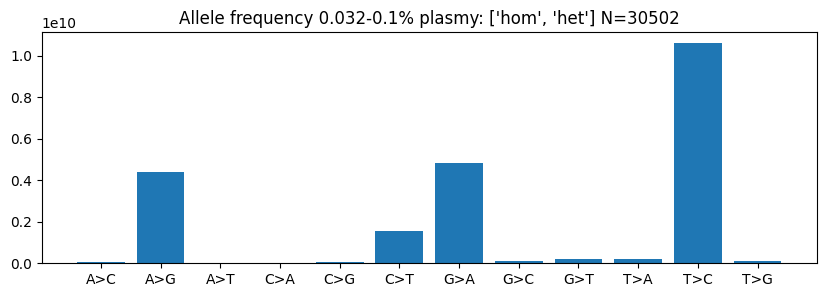

In [127]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search_gnomad(only_syn_gnomad_df)

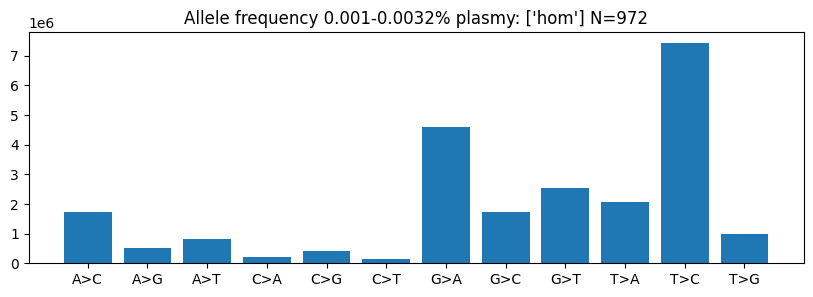

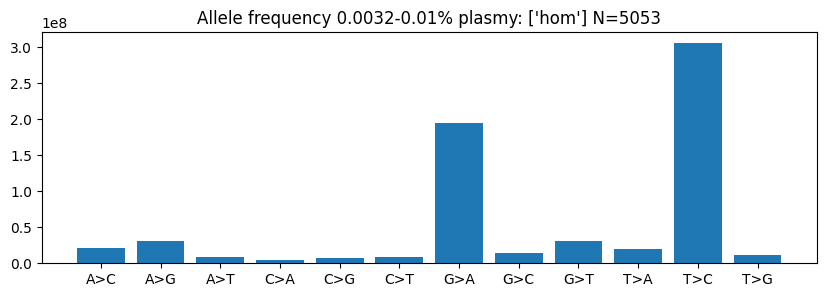

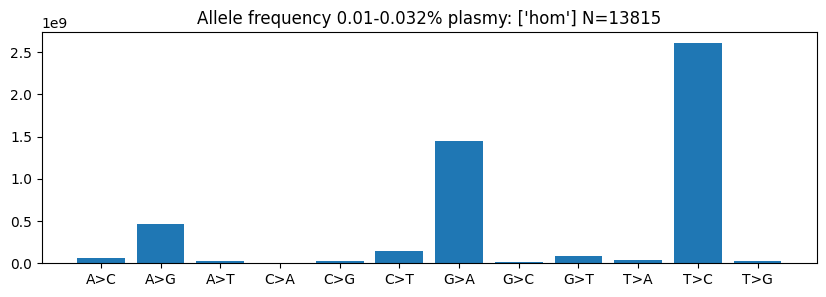

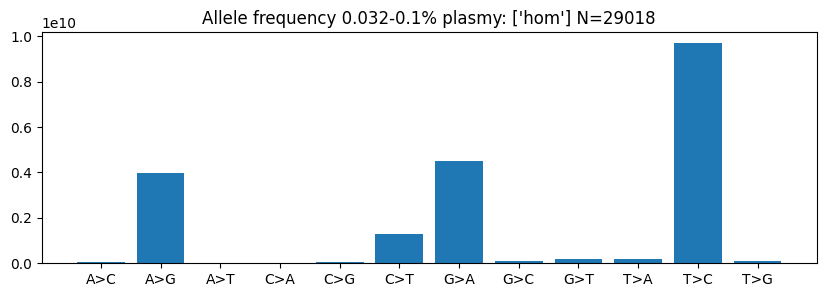

In [128]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search_gnomad(only_syn_gnomad_df, plasmy=['AC_hom'])

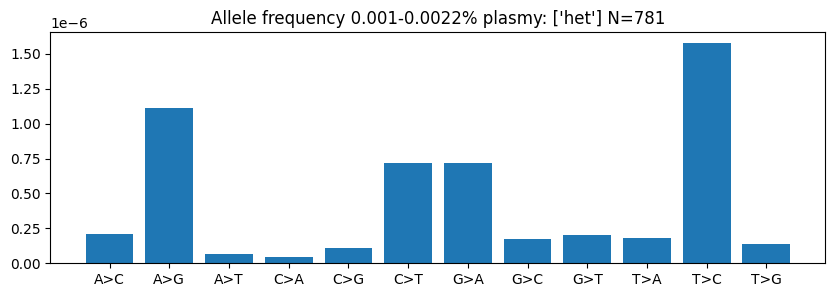

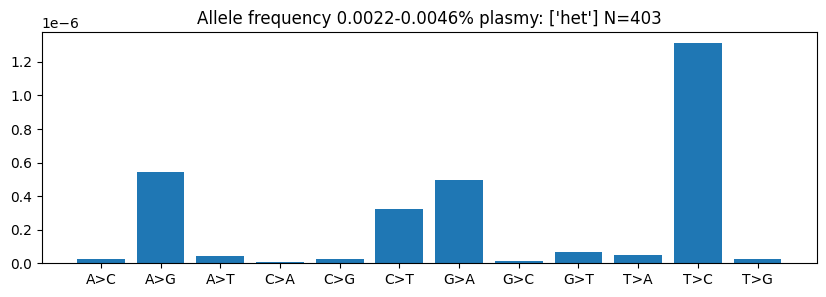

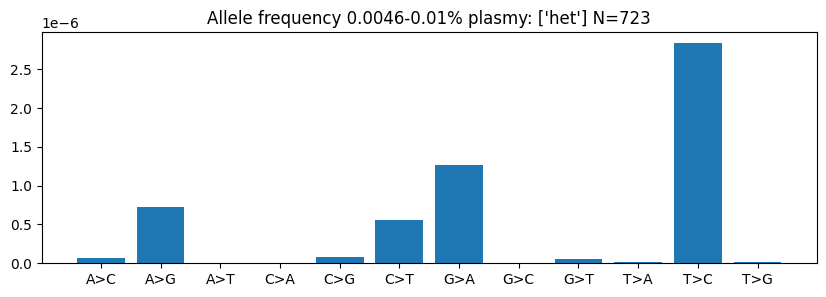

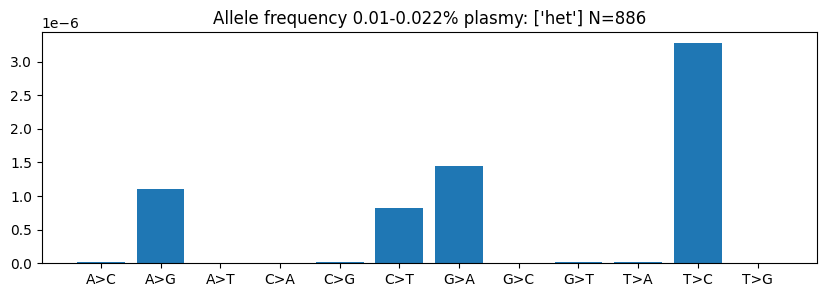

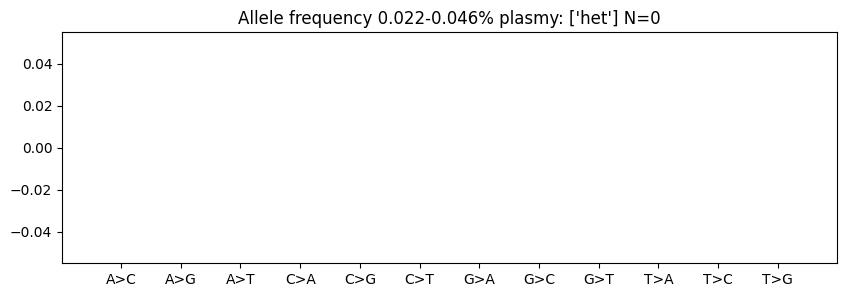

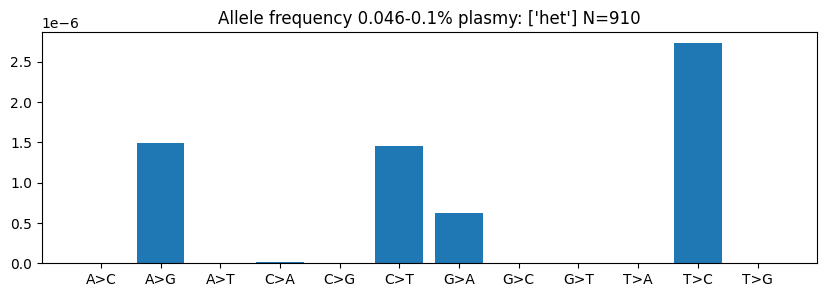

In [111]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search_gnomad(only_syn_gnomad_df, plasmy=['AC_het'])

In [89]:
plasmy=['AC_hom', 'AC_hom']
# subs_number = only_syn_gnomad_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,plasmy].sum(axis=1)
# subs_number
subs_freq_df = only_syn_gnomad_df.loc[:,['AF_hom', 'AF_het']].sum(axis=1)
threshold_df = only_syn_gnomad_df[(subs_freq_df >= 0.01) & (subs_freq_df < 0.1)]
subs_number = threshold_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,plasmy].sum(axis=1)
subs_number['A','C'] = 0
subs_number = threshold_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,plasmy].sum(axis=1)
subs_number

ref  alt
A    G      173628
     T        3896
C    A       13856
     T       79682
G    A      187586
     C        6356
T    A        7884
     C      169520
dtype: int64

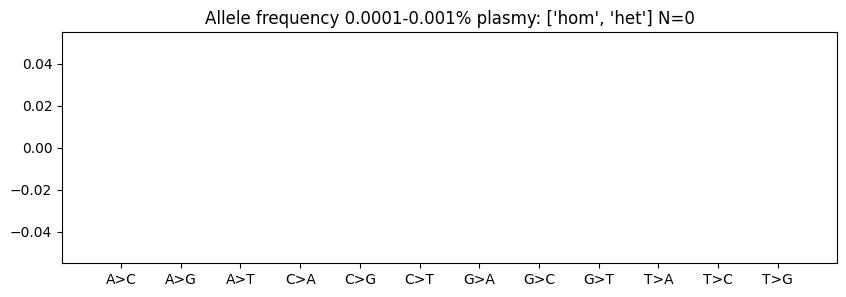

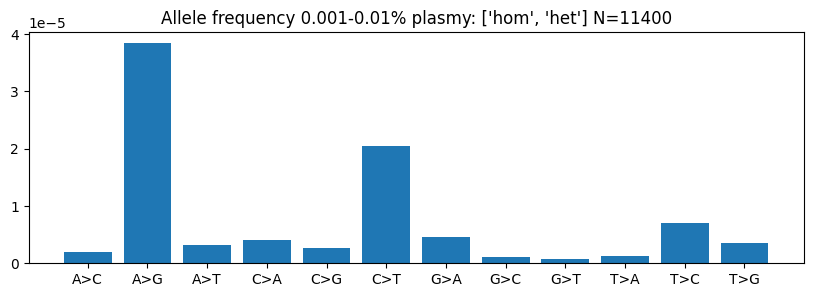

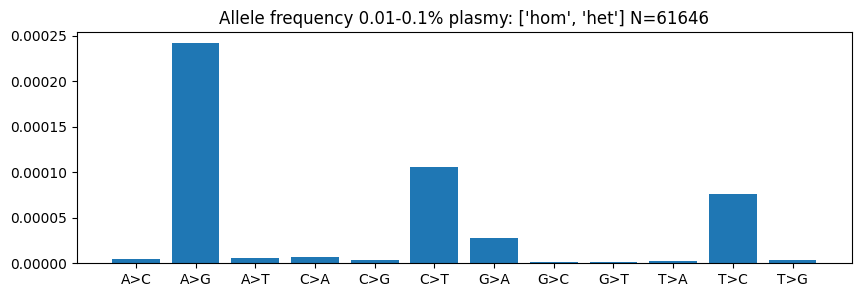

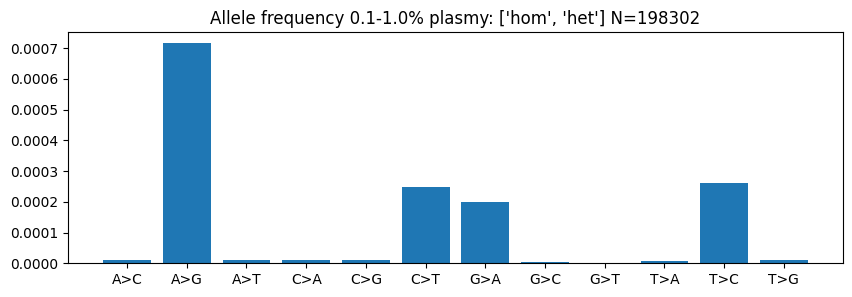

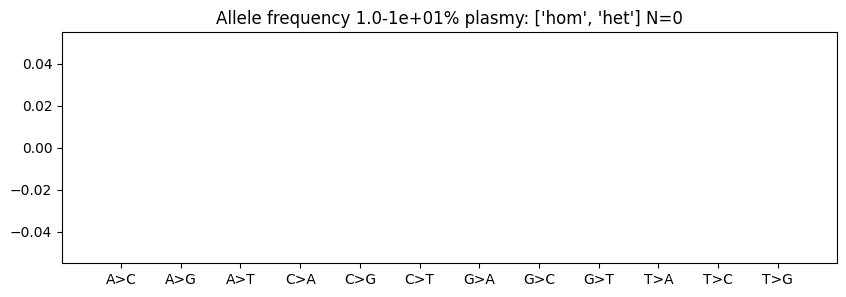

In [154]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search_gnomad(only_subs_gnomad_df)